In [26]:
import os
import sys
import json
import pickle

from embedding import BertHuggingface

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import functools

import numpy as np
import math
import random
import scipy
import yaml

sys.path.append(os.path.abspath(".."))
import plotting
import utils

In [30]:
CONFIGS_BASE = ['../configs/pie_performance/baseline_nn.json', '../configs/pie_performance/baseline_lvq_sklearn.json']

CONFIGS_CBM = ['../configs/pie_performance/cbm_lin.json', '../configs/pie_performance/cbm_mlp2.json', '../configs/pie_performance/cbm_mlp3.json']

CONFIGS_PIE = ['../configs/pie_performance/pie_nn.json', '../configs/pie_performance/pie_lvq.json', '../configs/pie_performance/pie_sklearn.json']

# TODO CAV

In [10]:
CONFIGS_BASE = ['../configs/performance_baseline/bert.json', '../configs/performance_baseline/facebook.json', '../configs/performance_baseline/llama.json', '../configs/performance_baseline/pythia.json', 
                '../configs/performance_baseline/deepseek.json', '../configs/performance_baseline/google.json', '../configs/performance_baseline/openai.json', '../configs/performance_baseline/xlnet.json']

CONFIGS_CBM = ['../configs/performance_cbm/bert_xlnet.json', '../configs/performance_cbm/google_facebook.json', '../configs/performance_cbm/llama.json', 
               '../configs/performance_cbm/openai_pythia.json', '../configs/performance_cbm/deepseek.json']

CONFIGS_PIE = ['../configs/performance_pie/bert_xlnet.json', '../configs/performance_pie/google_facebook.json', '../configs/performance_pie/llama.json', 
               '../configs/performance_pie/openai_pythia.json', '../configs/performance_pie/deepseek.json']

# TODO CAV

## Merge all results

In [31]:
def get_merged_config_results(config_files, performance_filename, concept_filename=None):
    print('load %s' % config_files[0])
    with open(config_files[0], 'r') as f:
        config = json.load(f)
    results = [pd.read_csv('../../'+config['results_path'])]
    if concept_filename is not None:
        results_concept = [pd.read_csv('../../'+config['results_path'].replace('.csv', '_concept.csv'))]

    for cfg in config_files:
        print('load %s' % cfg)
        with open(cfg, 'r') as f:
            next_config = json.load(f)
            perf_file = '../../'+next_config['results_path']
            if os.path.isfile(perf_file):
                results.append(pd.read_csv(perf_file))
            if concept_filename is not None:
                concept_file = '../../'+next_config['results_path'].replace('.csv', '_concept.csv')
                if os.path.isfile(concept_file):
                    results_concept.append(pd.read_csv(concept_file))
            
            config['openai_models'] += next_config['openai_models']
            config['huggingface_models'] += next_config['huggingface_models']

            for key in config.keys():
                if key in ['openai_models', 'huggingface_models', 'results_path', 'classifier'] or key not in next_config.keys():
                    continue
                assert config[key] == next_config[key], key

    results = pd.concat(results)
    results = results.reset_index()
    if concept_filename is not None:
        results_concept = pd.concat(results_concept)
        results_concept = results_concept.reset_index()
        return config, results, results_concept

    return config, results

base_config, results_base = get_merged_config_results(CONFIGS_BASE, 'baseline_results.csv')
cbm_config, results_cbm, results_cbm_concept = get_merged_config_results(CONFIGS_CBM, 'cbm_performance_results.csv', 'cbm_concept_results.csv')
pie_config, results_pie, results_pie_concept = get_merged_config_results(CONFIGS_PIE, 'pie_performance_results.csv', 'pie_concept_results.csv')
# TODO cav

load ../configs/pie_performance/baseline_nn.json
load ../configs/pie_performance/baseline_nn.json
load ../configs/pie_performance/baseline_lvq_sklearn.json
load ../configs/pie_performance/cbm_lin.json
load ../configs/pie_performance/cbm_lin.json
load ../configs/pie_performance/cbm_mlp2.json
load ../configs/pie_performance/cbm_mlp3.json
load ../configs/pie_performance/pie_nn.json
load ../configs/pie_performance/pie_nn.json
load ../configs/pie_performance/pie_lvq.json
load ../configs/pie_performance/pie_sklearn.json


In [32]:
results_pie.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'protected concepts', 'other concepts', 'method protected',
       'method unsupervised', 'remove protected', 'optimizer', 'lr', 'loss',
       'F1', 'Precision', 'Recall', 'Epochs', 'Predictions', 'rf_n_estimators',
       'lvq_class', 'lvq_min_prototypes', 'lvq_prototype_ratio',
       'lvq_max_ratio'],
      dtype='object')

In [33]:
results_base.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'optimizer', 'lr', 'loss', 'F1', 'Precision', 'Recall', 'Epochs',
       'Predictions', 'rf_n_estimators', 'lvq_class', 'lvq_min_prototypes',
       'lvq_prototype_ratio', 'lvq_max_ratio'],
      dtype='object')

In [34]:
results_cbm.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'protected concepts', 'other concepts', 'lambda', 'optimizer', 'lr',
       'loss', 'F1', 'Precision', 'Recall', 'Epochs', 'Predictions'],
      dtype='object')

In [35]:
results_base = results_base[results_base['architecture'] == 'embedder']

In [36]:
res_base = results_base.copy()
res_base['other concepts'] = res_base['emb size']
res_base['protected concepts'] = 0
res_base['method protected'] = ''
res_base['method unsupervised'] = ''

res_cbm = results_cbm.copy()
res_cbm['method protected'] = 'cbm'
res_cbm['method unsupervised'] = 'cbm'

res_pie = results_pie.copy().drop(columns=['remove protected'])

# merge performance results
res_perf = pd.concat([res_pie, res_cbm, res_base])
res_perf = res_perf.reset_index()

res_perf

,level_0,index,dataset,model,model type,architecture,method,pooling,classifier,clf hidden size factor,...,Precision,Recall,Epochs,Predictions,rf_n_estimators,lvq_class,lvq_min_prototypes,lvq_prototype_ratio,lvq_max_ratio,lambda
0,0,0,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,/,linear,-1.0,...,0.694536,0.724797,10.0,../artifacts/pie_predictions_main/20250929_090...,-1.0,linear,-1.0,NaN,-1.0,NaN
1,1,1,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,/,linear,-1.0,...,0.633131,0.740817,10.0,../artifacts/pie_predictions_main/20250929_091...,-1.0,linear,-1.0,NaN,-1.0,NaN
2,2,2,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,/,linear,-1.0,...,0.698161,0.749793,15.0,../artifacts/pie_predictions_main/20250929_091...,-1.0,linear,-1.0,NaN,-1.0,NaN
3,3,3,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,/,linear,-1.0,...,0.729294,0.734509,13.0,../artifacts/pie_predictions_main/20250929_091...,-1.0,linear,-1.0,NaN,-1.0,NaN
4,4,4,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,/,linear,-1.0,...,0.658147,0.774151,10.0,../artifacts/pie_predictions_main/20250929_091...,-1.0,linear,-1.0,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27897,1185,485,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,GLVQ,-1.0,...,0.000000,0.000000,0.0,na,-1.0,GLVQ,1.0,weighted,10.0,NaN
27898,1186,486,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,GLVQ,-1.0,...,0.000000,0.000000,0.0,na,-1.0,GLVQ,3.0,weighted,5.0,NaN
27899,1187,487,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,GLVQ,-1.0,...,0.000000,0.000000,0.0,na,-1.0,GLVQ,3.0,weighted,10.0,NaN
27900,1188,488,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,GLVQ,-1.0,...,0.000000,0.000000,0.0,na,-1.0,GLVQ,5.0,weighted,5.0,NaN


In [37]:
# shared test groups
groups_test = set(results_pie_concept['group (test)'])

# filter results for these groups and rename columns
res_cbm_concept = results_cbm_concept.copy()
res_cbm_concept = res_cbm_concept[res_cbm_concept['group'].isin(groups_test)]
res_cbm_concept = res_cbm_concept.rename(columns={'group': 'group (test)'})
res_cbm_concept = res_cbm_concept.drop(columns=['lambda'])

res_pie_concept = results_pie_concept.copy()
res_pie_concept = res_pie_concept.drop(columns=['group (pie)'])
res_pie_concept = res_pie_concept.drop(columns=['method protected'])
res_pie_concept = res_pie_concept.drop(columns=['method unsupervised'])
res_pie_concept = res_pie_concept.drop(columns=['remove protected'])

# merge concept results
res_concept = pd.concat([res_cbm_concept, res_pie_concept])
res_concept = res_concept.reset_index()

res_concept

,level_0,index,dataset,model,model type,architecture,method,pooling,classifier,clf hidden size factor,...,other concepts,optimizer,lr,loss,group (test),Pearson R,pvalue,PR-AUC,Epochs,concepts
0,0,0,sbic,bert-base-uncased,bert,encoder,cbm,mean,linear,-1.0,...,10,Salsa,NaN,BCEWithLogitsLoss,white,0.125334,6.199785e-18,0.089352,11,../artifacts/pie_predictions_main/20250929_090...
1,1,1,sbic,bert-base-uncased,bert,encoder,cbm,mean,linear,-1.0,...,10,Salsa,NaN,BCEWithLogitsLoss,black,0.666176,0.000000e+00,0.807524,11,../artifacts/pie_predictions_main/20250929_090...
2,2,2,sbic,bert-base-uncased,bert,encoder,cbm,mean,linear,-1.0,...,10,Salsa,NaN,BCEWithLogitsLoss,asian,0.310691,8.028079e-106,0.338559,11,../artifacts/pie_predictions_main/20250929_090...
3,4,4,sbic,bert-base-uncased,bert,encoder,cbm,mean,linear,-1.0,...,10,Salsa,NaN,BCEWithLogitsLoss,latin-american,0.152949,5.047880e-26,0.181594,11,../artifacts/pie_predictions_main/20250929_090...
4,5,5,sbic,bert-base-uncased,bert,encoder,cbm,mean,linear,-1.0,...,10,Salsa,NaN,BCEWithLogitsLoss,hispanic,0.268759,1.174226e-78,0.267177,11,../artifacts/pie_predictions_main/20250929_090...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331849,159393,11425,bios-supervised,meta-llama/Llama-3.2-1B,llama,decoder,pie,mean,RandomForest,-1.0,...,200,Salsa,NaN,BCEWithLogitsLoss,male,0.946432,0.000000e+00,0.999913,-1.0,../artifacts/pie_predictions_main/20251006_170...
331850,159394,11426,bios-supervised,meta-llama/Llama-3.2-1B,llama,decoder,pie,mean,RandomForest,-1.0,...,200,Salsa,NaN,BCEWithLogitsLoss,female,0.946432,0.000000e+00,0.999869,-1.0,../artifacts/pie_predictions_main/20251006_171...
331851,159395,11427,bios-supervised,meta-llama/Llama-3.2-1B,llama,decoder,pie,mean,RandomForest,-1.0,...,200,Salsa,NaN,BCEWithLogitsLoss,male,0.946432,0.000000e+00,0.999913,-1.0,../artifacts/pie_predictions_main/20251006_171...
331852,159396,11428,bios-supervised,meta-llama/Llama-3.2-1B,llama,decoder,pie,mean,RandomForest,-1.0,...,200,Salsa,NaN,BCEWithLogitsLoss,female,0.946432,0.000000e+00,0.999869,-1.0,../artifacts/pie_predictions_main/20251006_171...


## Plotting utils

In [38]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)

    ax.set_ylim(-0.05, 1.05)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(7*len(subplot_choices), 6))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0))
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## Performance plots

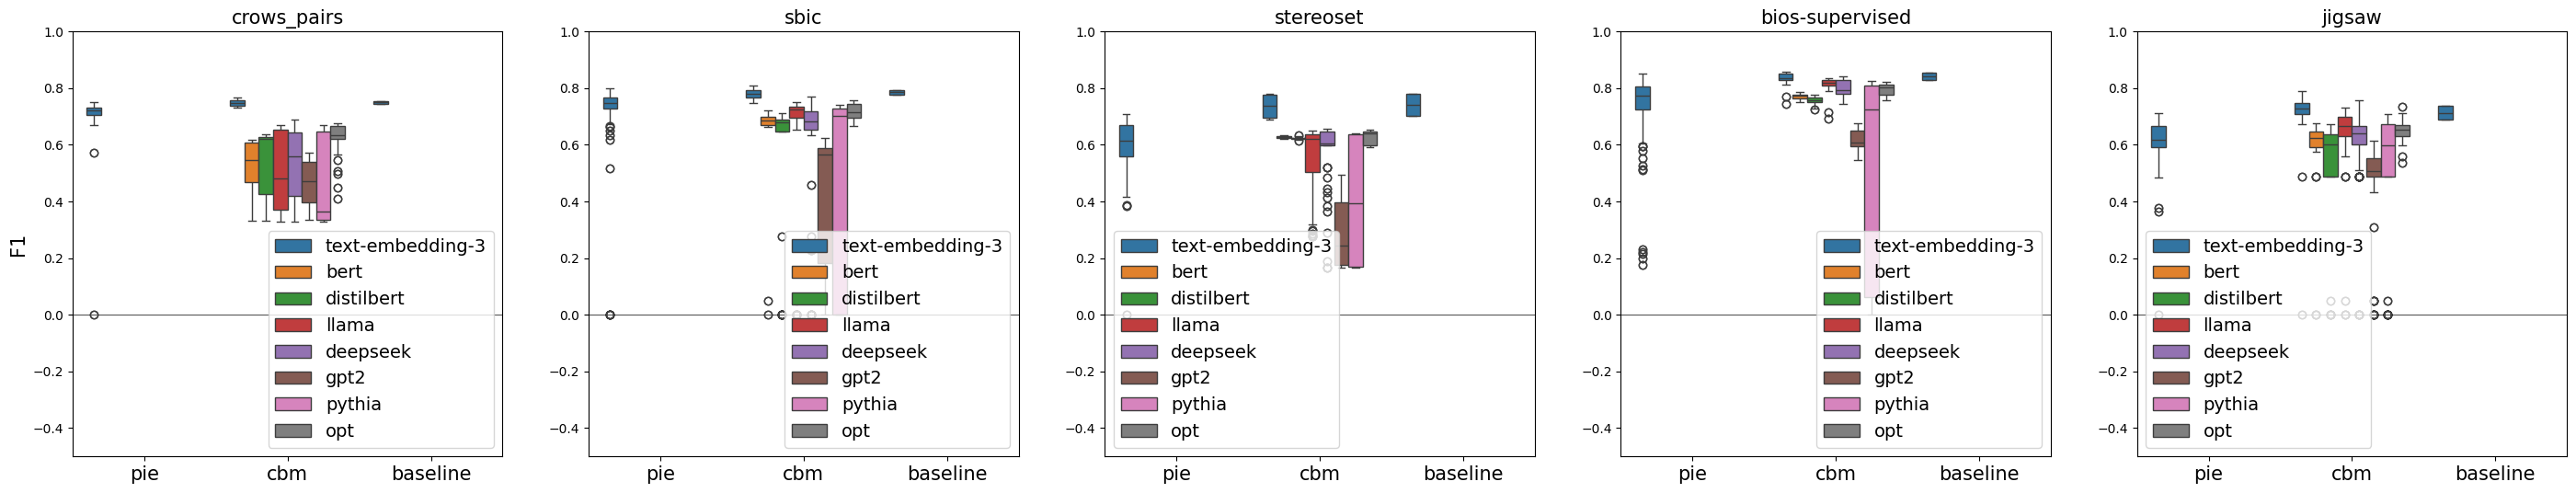

In [45]:
multipot(res_perf[res_perf['classifier'] == 'linear'], subplot_col='dataset', xcol='method', ycol='F1', huecol='model type', remove_legend=False)#, savefile='plots/performance_arch.eps')

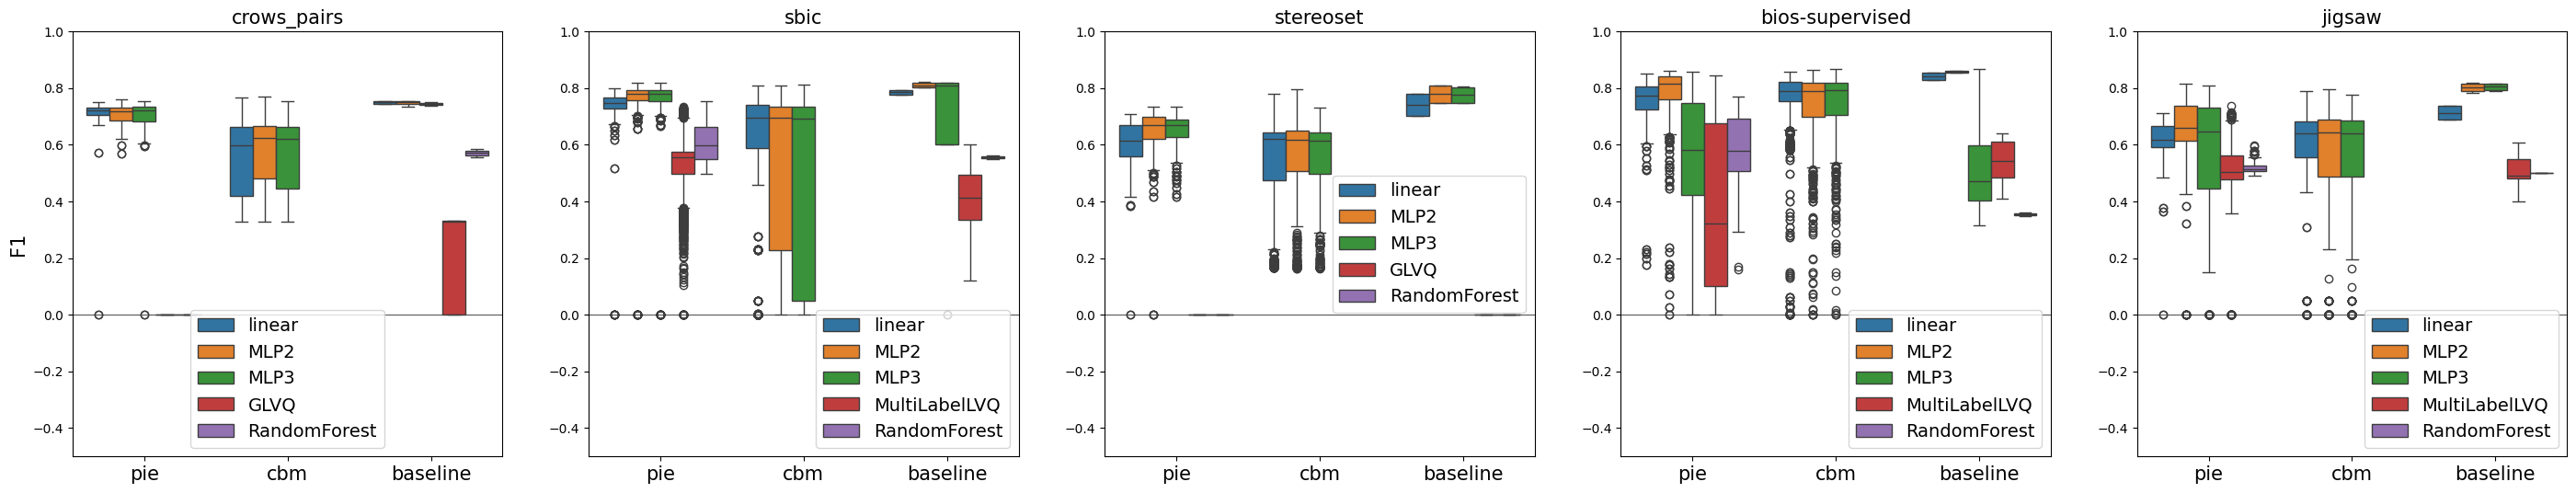

In [46]:
multipot(res_perf, subplot_col='dataset', xcol='method', ycol='F1', huecol='classifier', remove_legend=False)#, savefile='plots/performance_clf.png')

In [ ]:
multipot(res_perf, subplot_col='dataset', xcol='method', ycol='F1', huecol='model type', remove_legend=False)

In [ ]:
res = res_perf[res_perf['classifier'] != 'linear']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='F1', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

In [ ]:
res = res_perf[res_perf['classifier'] == 'linear']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='F1', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

In [ ]:
multipot(res_perf, subplot_col='dataset', xcol='method', ycol='F1', huecol='other concepts', remove_legend=False)

In [20]:
res_cbm_concept.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'protected concepts', 'other concepts', 'optimizer', 'lr', 'loss',
       'group (test)', 'Pearson R', 'pvalue', 'PR-AUC', 'Epochs', 'concepts'],
      dtype='object')

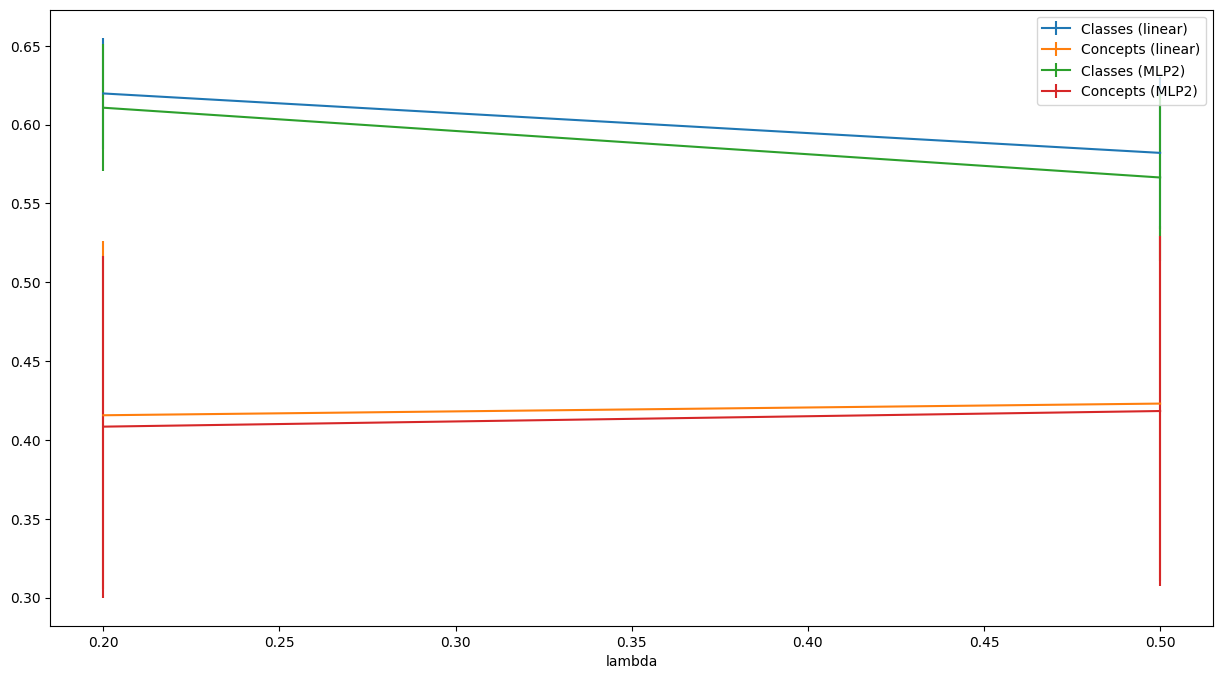

In [49]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

fig, ax = plt.subplots(figsize=(15,8))
for clf in ['linear', 'MLP2']:
    res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == clf], sel_cols=['lambda'], target_col='F1')
    conc_cbm_ = aggregate_results(results_cbm_concept[results_cbm_concept['classifier'] == clf], sel_cols=['lambda'], target_col='PR-AUC')
    
    ax.errorbar(x=res_cbm_['lambda'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='Classes (%s)' % clf)
    ax.errorbar(x=conc_cbm_['lambda'], y=conc_cbm_['PR-AUC'], yerr=conc_cbm_['PR-AUC var'], label='Concepts (%s)' % clf)
    ax.set_xlabel('lambda')
    ax.legend()

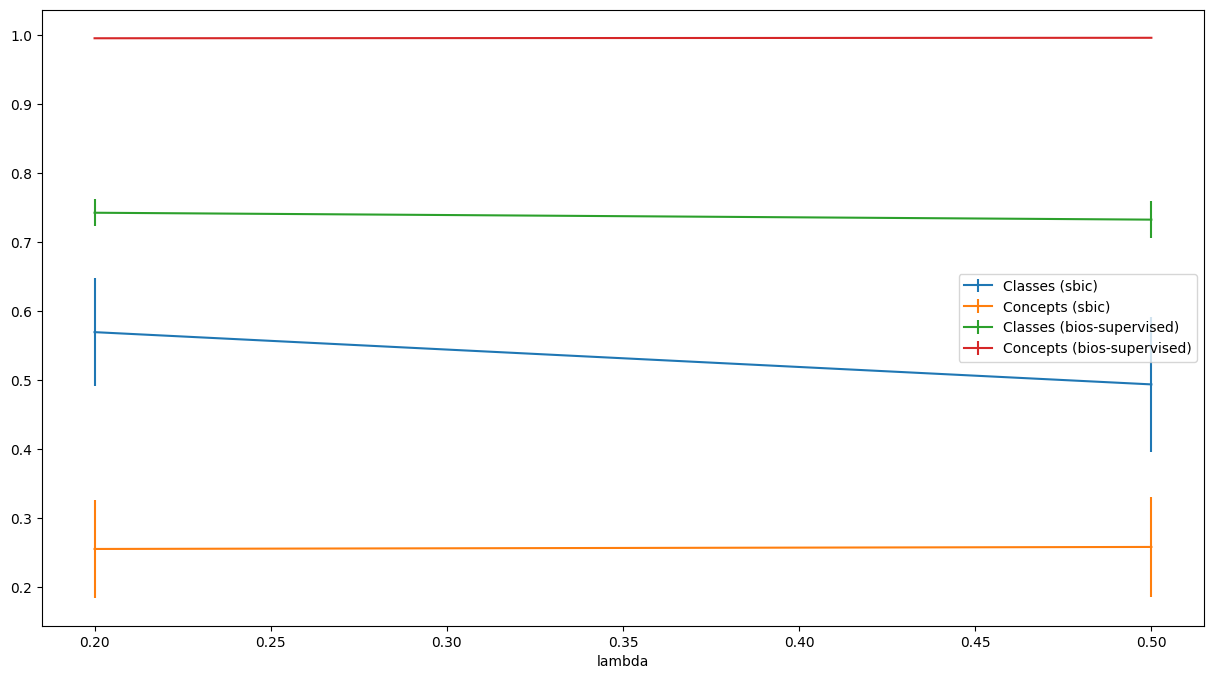

In [50]:
fig, ax = plt.subplots(figsize=(15,8))
for dataset in ['sbic', 'bios-supervised']:
    res_cbm_ = aggregate_results(res_cbm[res_cbm['dataset'] == dataset], sel_cols=['lambda'], target_col='F1')
    conc_cbm_ = aggregate_results(results_cbm_concept[results_cbm_concept['dataset'] == dataset], sel_cols=['lambda'], target_col='PR-AUC')
    
    ax.errorbar(x=res_cbm_['lambda'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='Classes (%s)' % dataset)
    ax.errorbar(x=conc_cbm_['lambda'], y=conc_cbm_['PR-AUC'], yerr=conc_cbm_['PR-AUC var'], label='Concepts (%s)' % dataset)
    ax.set_xlabel('lambda')
    ax.legend()

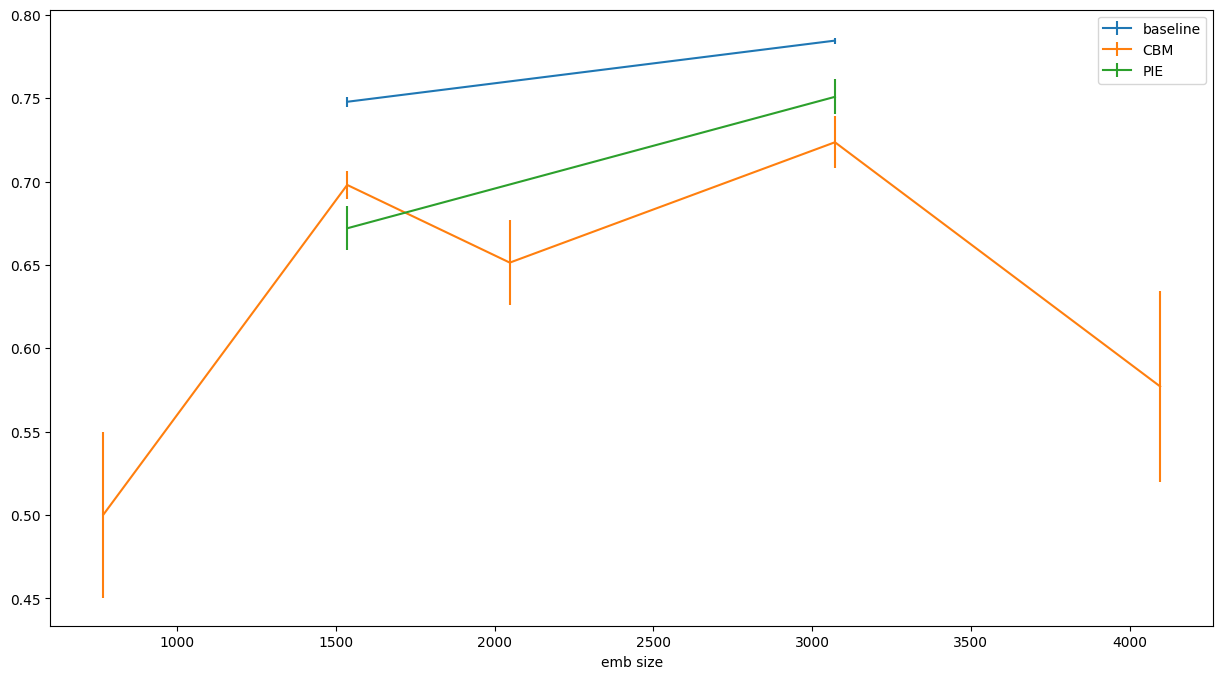

In [51]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

res_base_ = aggregate_results(res_base[res_base['classifier'] == 'linear'], sel_cols=['emb size'], target_col='F1')
res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == 'linear'], sel_cols=['emb size'], target_col='F1')
res_pie_ = aggregate_results(res_pie[res_pie['classifier'] == 'linear'], sel_cols=['emb size'], target_col='F1')


fig, ax = plt.subplots(figsize=(15,8))
ax.errorbar(x=res_base_['emb size'], y=res_base_['F1'], yerr=res_base_['F1 var'], label='baseline')
ax.errorbar(x=res_cbm_['emb size'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='CBM')
ax.errorbar(x=res_pie_['emb size'], y=res_pie_['F1'], yerr=res_pie_['F1 var'], label='PIE')
ax.set_xlabel('emb size')
ax.legend()

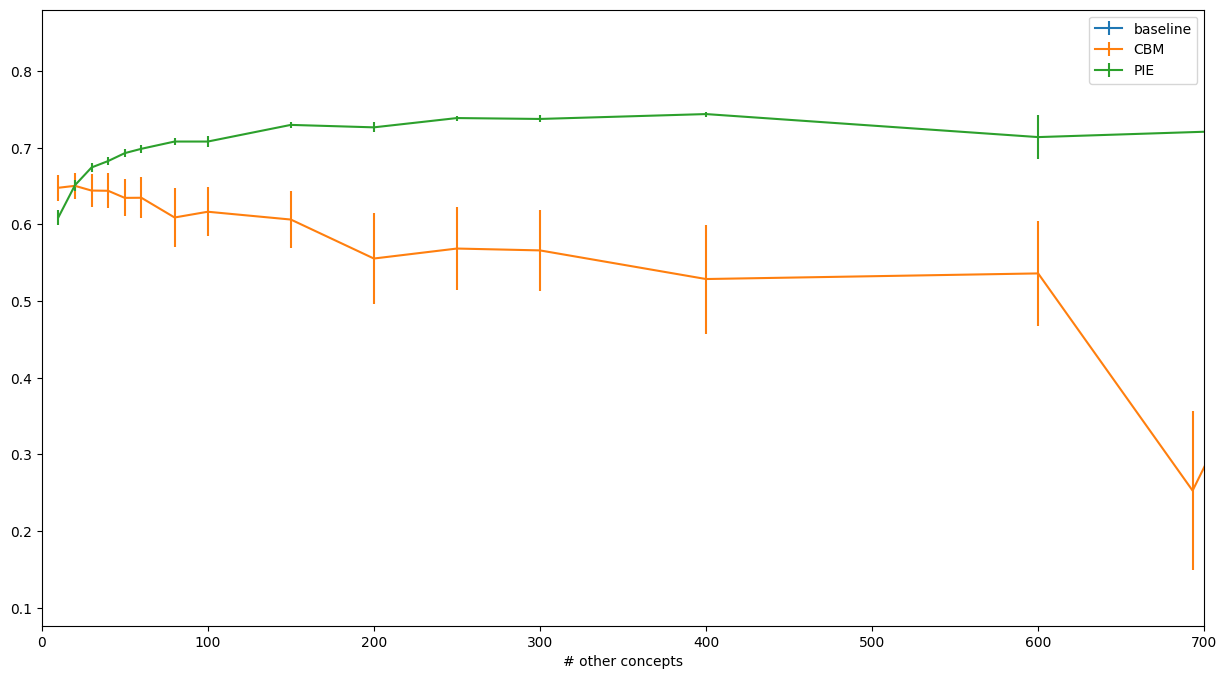

In [59]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

res_base_ = aggregate_results(res_base[res_base['classifier'] == 'linear'], sel_cols=['other concepts'], target_col='F1')
res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == 'linear'], sel_cols=['other concepts'], target_col='F1')
res_pie_ = aggregate_results(res_pie[res_pie['classifier'] == 'linear'], sel_cols=['other concepts'], target_col='F1')


fig, ax = plt.subplots(figsize=(15,8))
ax.errorbar(x=res_base_['other concepts'], y=res_base_['F1'], yerr=res_base_['F1 var'], label='baseline')
ax.errorbar(x=res_cbm_['other concepts'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='CBM')
ax.errorbar(x=res_pie_['other concepts'], y=res_pie_['F1'], yerr=res_pie_['F1 var'], label='PIE')
ax.set_xlabel('# other concepts')
ax.set_xlim(0, 700)
ax.legend()

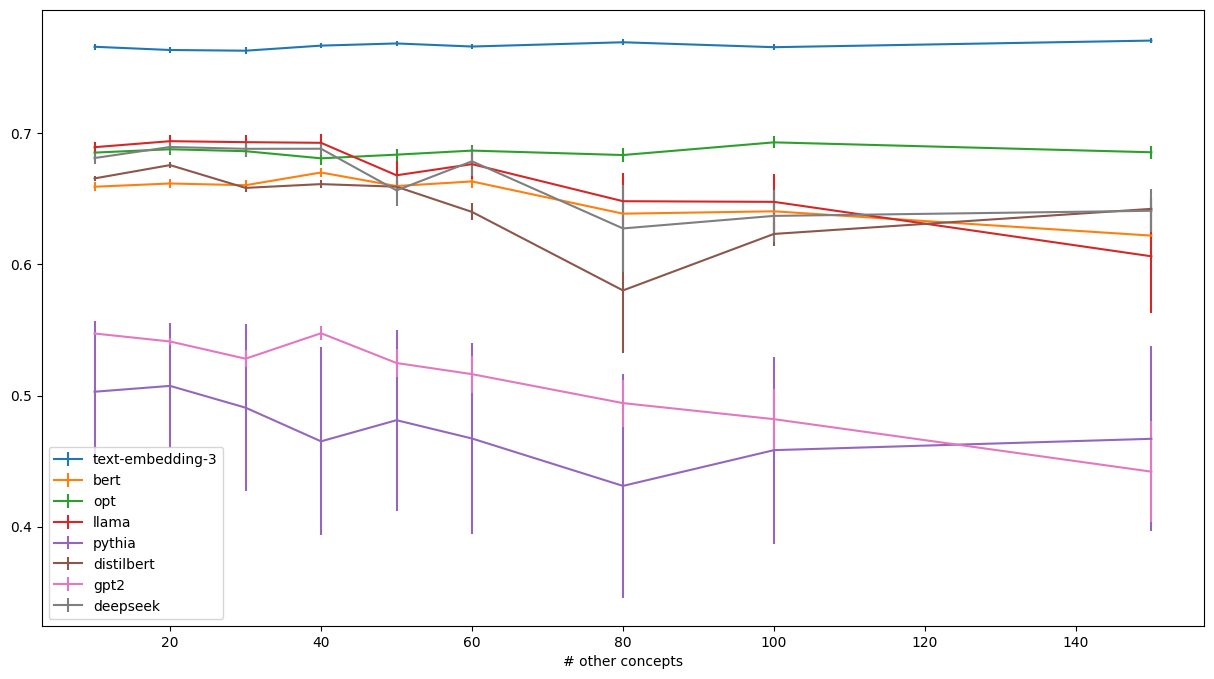

In [60]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == 'linear'], sel_cols=['other concepts', 'model type'], target_col='F1')
res_cbm_ = res_cbm_[res_cbm_['other concepts'] < 200]

fig, ax = plt.subplots(figsize=(15,8))
for model in set(res_cbm_['model type']):
    res_ = res_cbm_[res_cbm_['model type'] == model]
    ax.errorbar(x=res_['other concepts'], y=res_['F1'], yerr=res_['F1 var'], label=model)
ax.set_xlabel('# other concepts')
ax.legend()

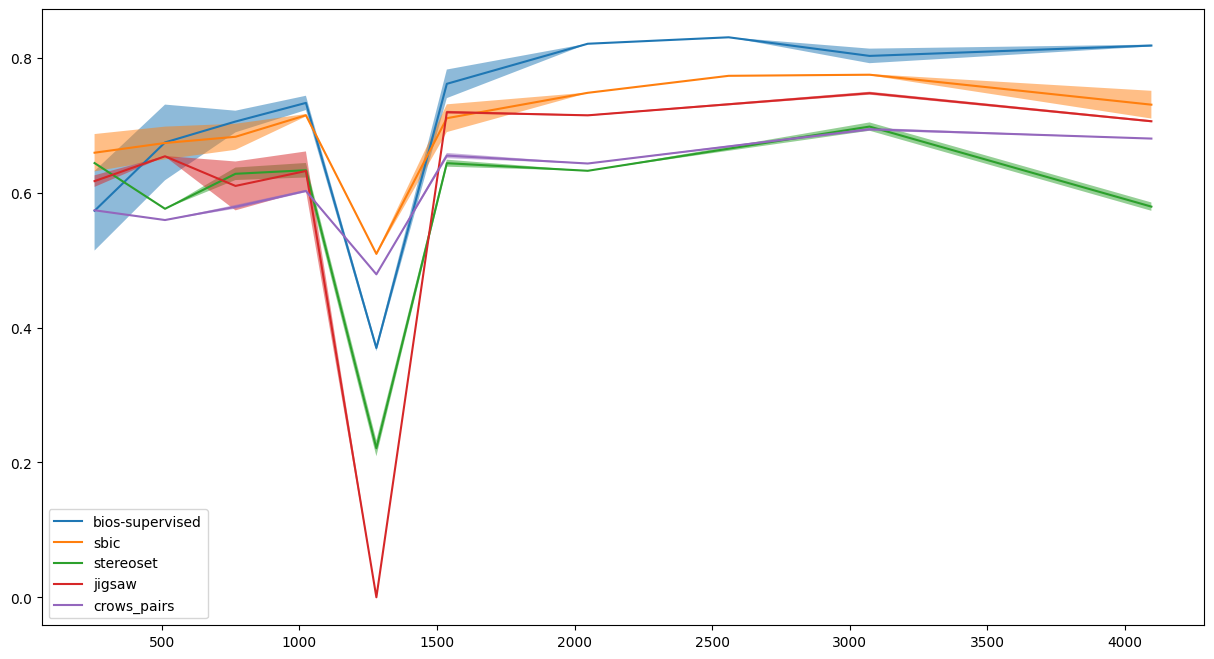

In [103]:
fig, ax = plt.subplots(figsize=(15,8))

for dataset in ['bios-supervised', 'sbic', 'stereoset', 'jigsaw', 'crows_pairs']:
    res_ = aggregate_results(res_base[res_base['dataset'] == dataset], sel_cols=['other concepts'], target_col='F1')
    y1 = res_['F1']-res_['F1 var']
    y2 = res_['F1']+res_['F1 var']

    ax.fill_between(res_['other concepts'], y1, y2, alpha=.5, linewidth=0)
    ax.plot(res_['other concepts'], res_['F1'], label=dataset)
ax.legend()

## Performance by number of other concepts

### 1) CBM

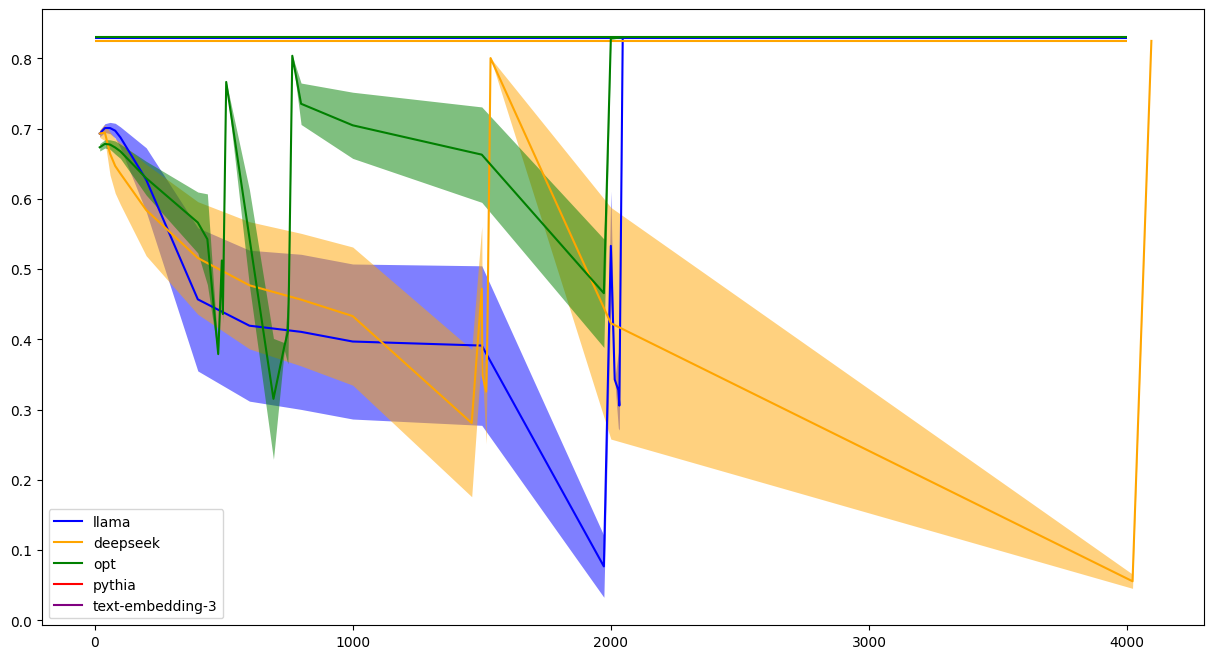

In [104]:
fig, ax = plt.subplots(figsize=(15,8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
for i, model_type in enumerate(['llama', 'deepseek', 'opt', 'pythia', 'text-embedding-3']):
    res_ = res_cbm[res_cbm['model type'] == model_type]
    res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

    max_y = np.max(res_agg['F1'])
    ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
    
    y1 = res_agg['F1']-res_agg['F1 var']
    y2 = res_agg['F1']+res_agg['F1 var']
    ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
    ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
ax.legend()

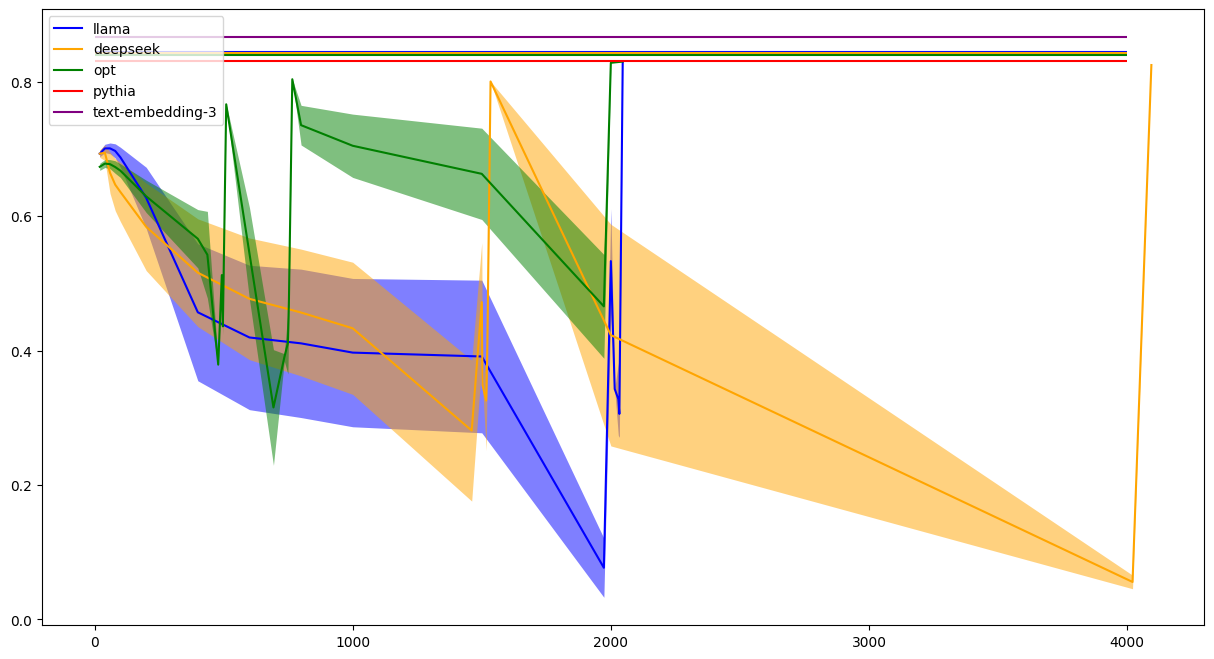

In [105]:
fig, ax = plt.subplots(figsize=(15,8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
for i, model_type in enumerate(['llama', 'deepseek', 'opt', 'pythia', 'text-embedding-3']):
    res_ = res_cbm[res_cbm['model type'] == model_type]
    res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

    max_y = np.max(res_base[res_base['model type'] == model_type]['F1'])
    ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
    
    y1 = res_agg['F1']-res_agg['F1 var']
    y2 = res_agg['F1']+res_agg['F1 var']
    ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
    ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
ax.legend()

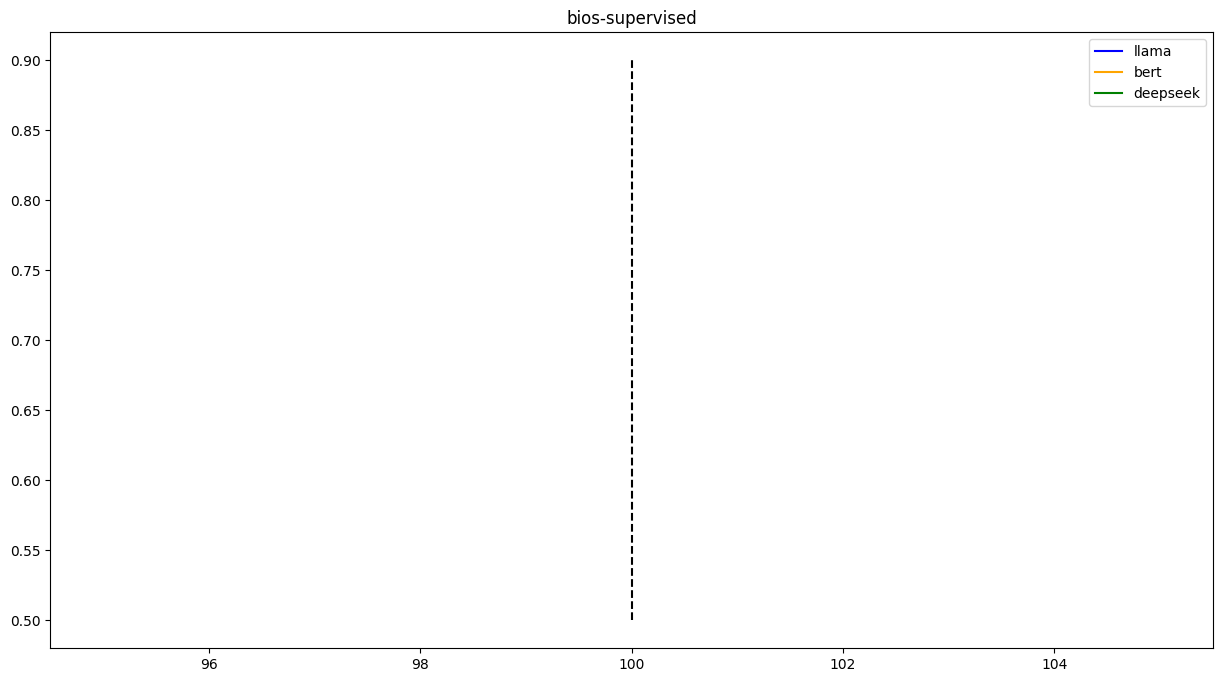

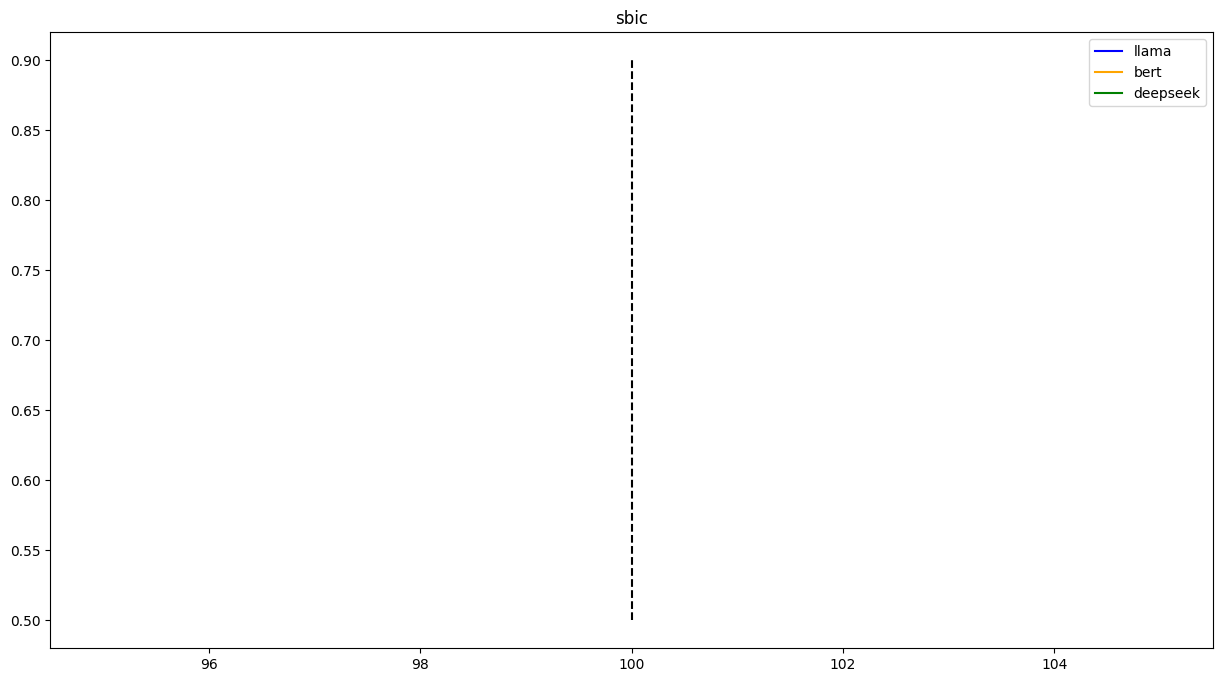

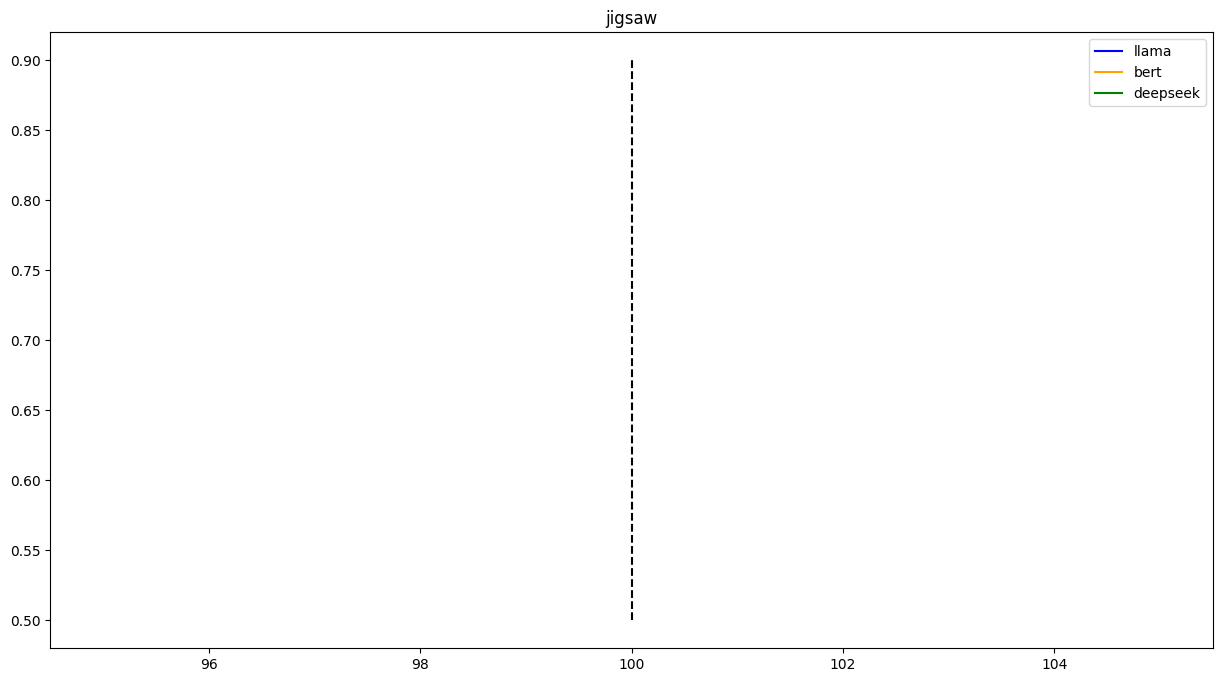

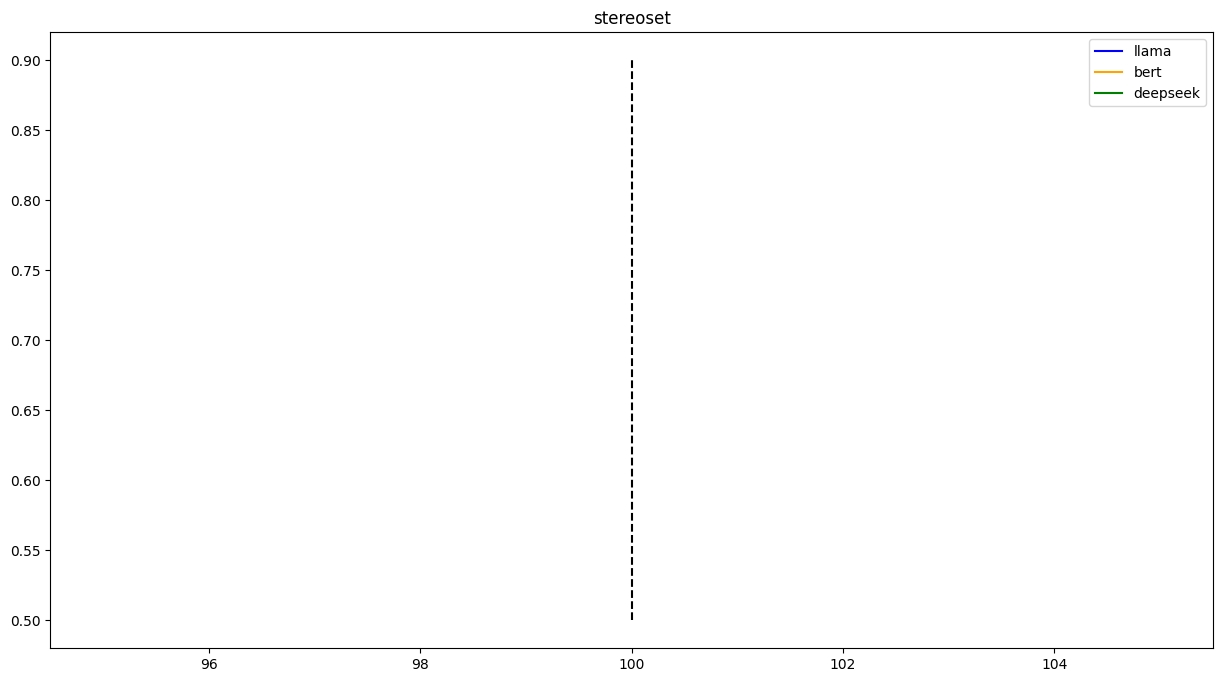

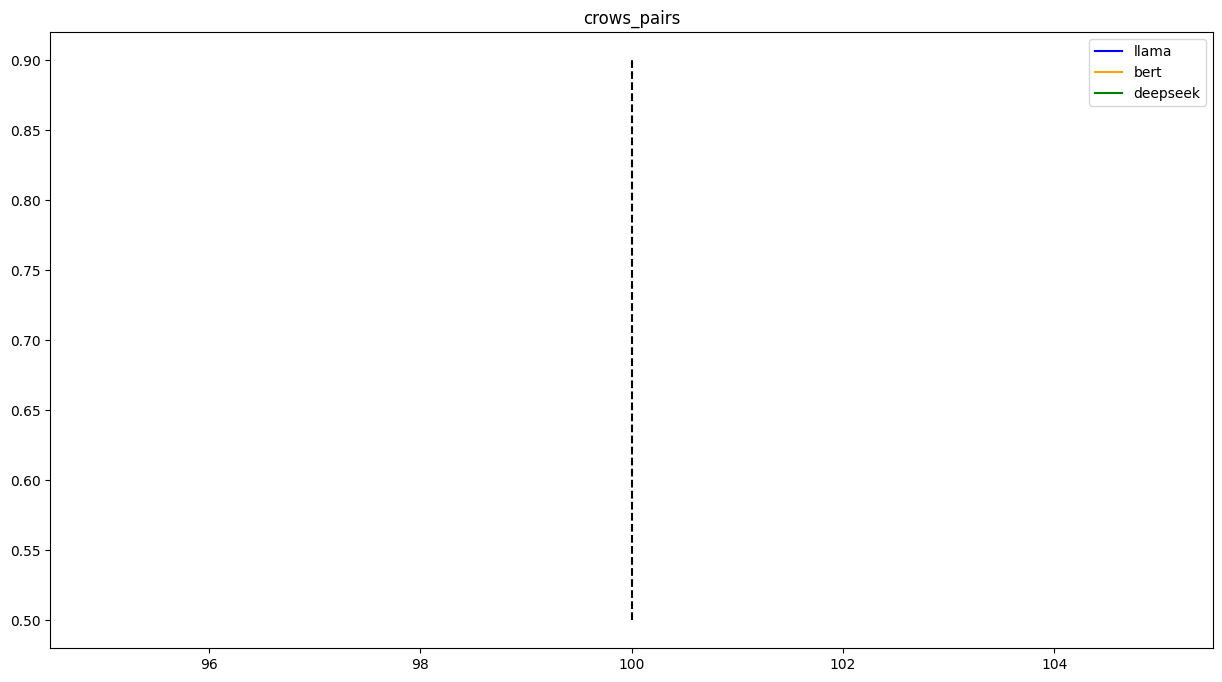

In [328]:
for dataset in ['bios-supervised', 'sbic', 'jigsaw', 'stereoset', 'crows_pairs']:
    fig, ax = plt.subplots(figsize=(15,8))
    res_base_ = res_base[res_base['dataset'] == dataset]
    res_base_ = aggregate_results(res_base_, sel_cols=['model type'], target_col='F1')
    ax.vlines(100, 0.5, 0.9, linestyle='--', colors='black')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
    for i, model_type in enumerate(['llama', 'bert', 'deepseek']):#, 'text-embedding-3']):
        res_ = res_cbm[res_cbm['classifier'] == 'linear']
        res_ = res_cbm[res_cbm['model type'] == model_type]
        res_ = res_[res_['dataset'] == dataset]
        res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

        emb_sizes = list(set(res_['emb size']))
        ax.vlines(emb_sizes, 0.5, 0.9, linestyle='--', colors=colors[i])
    
        max_y = np.max(res_base_[res_base_['model type'] == model_type]['F1'])
        ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
        
        y1 = res_agg['F1']-res_agg['F1 var']
        y2 = res_agg['F1']+res_agg['F1 var']
        ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
        ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
    ax.legend()
    ax.set_title(dataset)

### 2) PIE

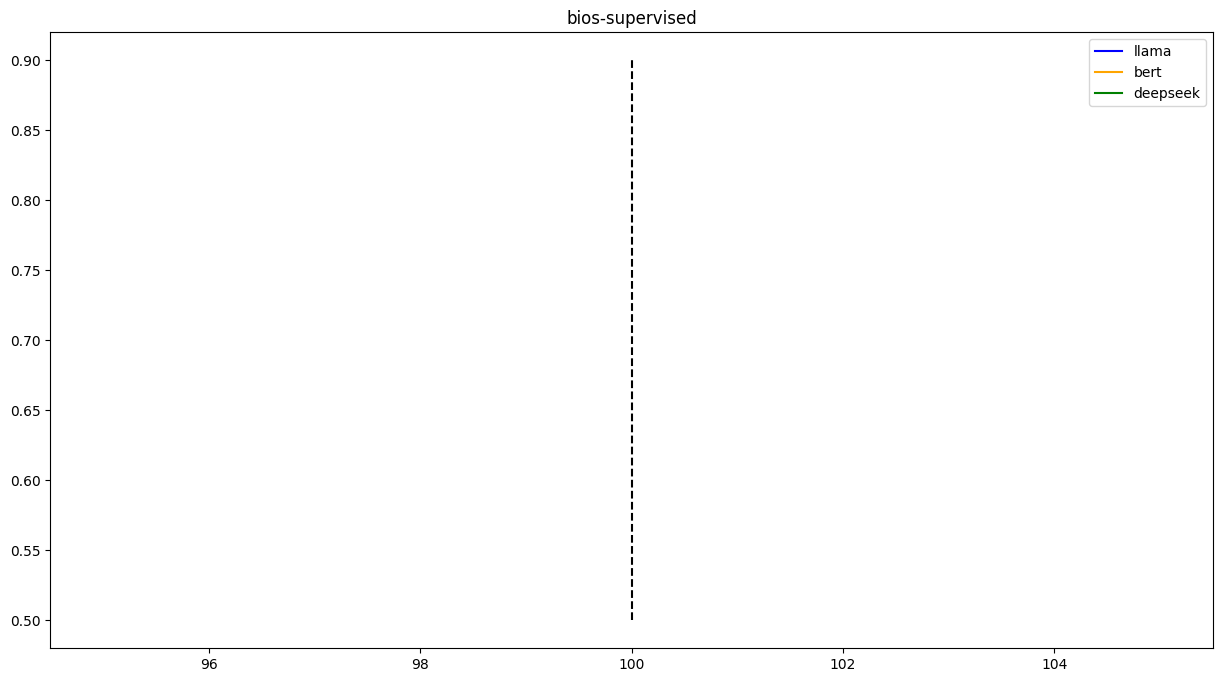

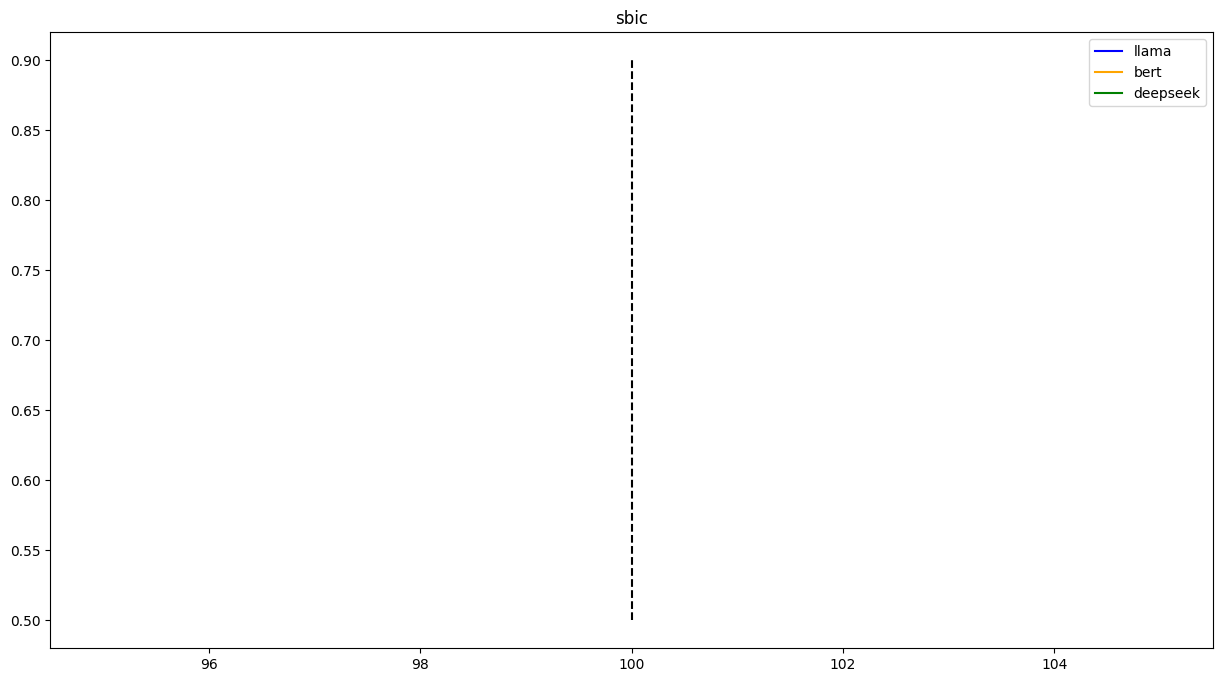

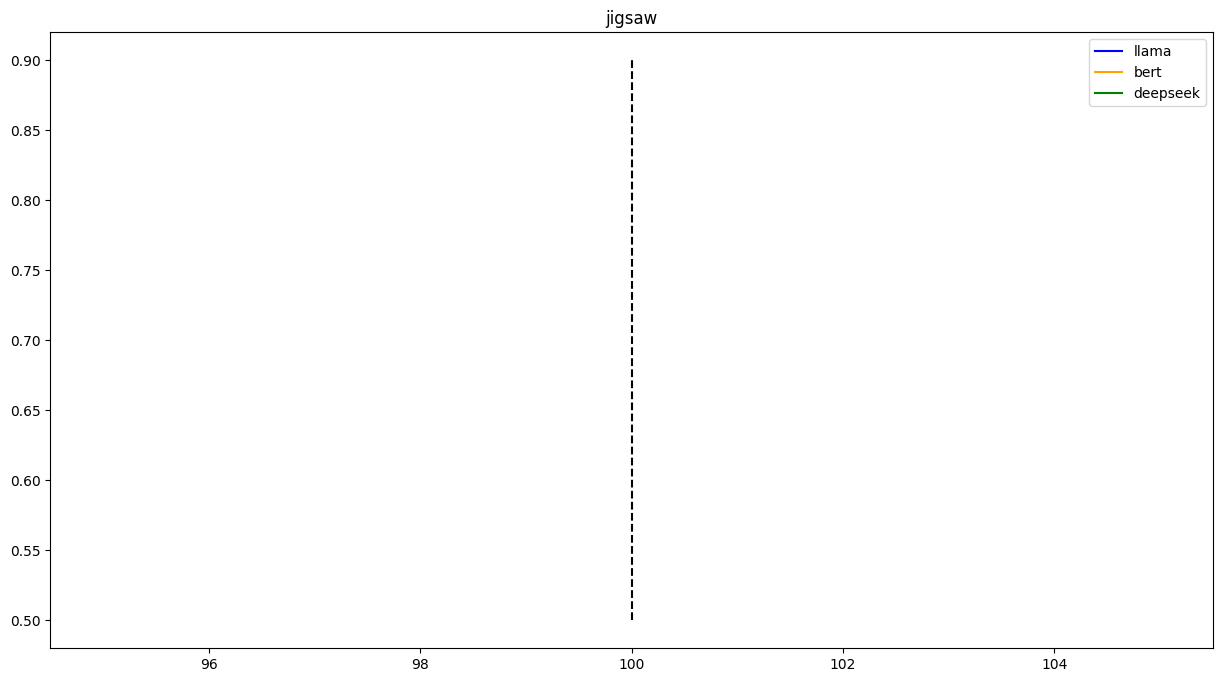

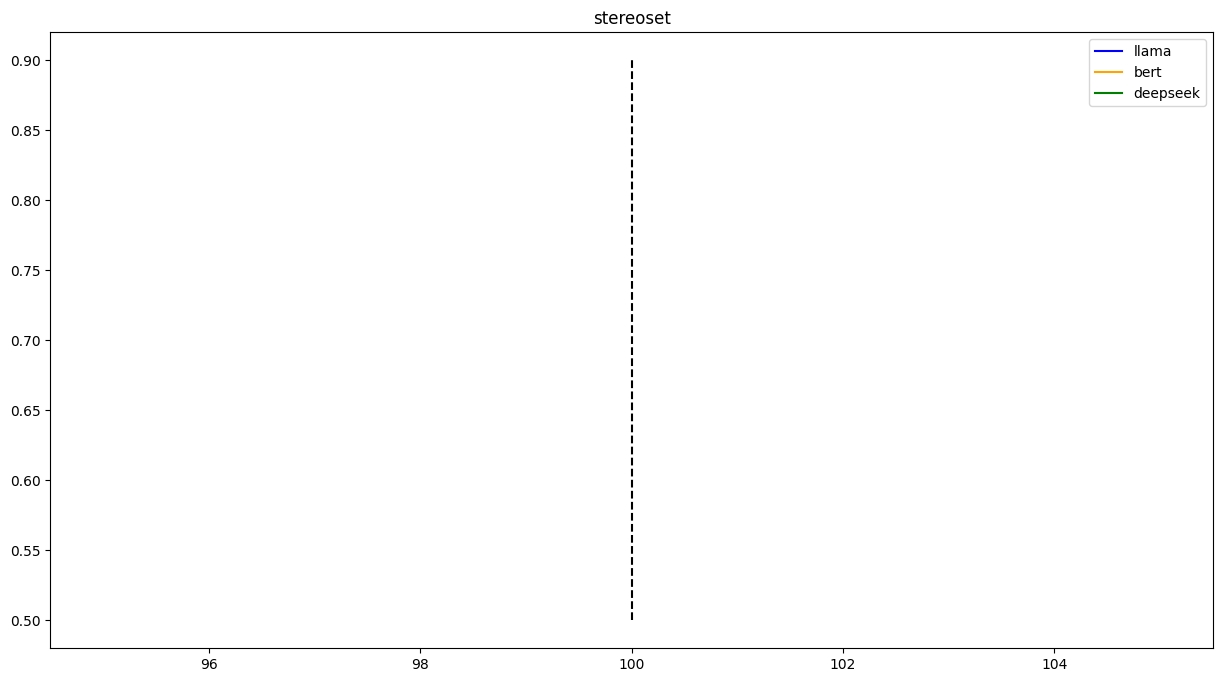

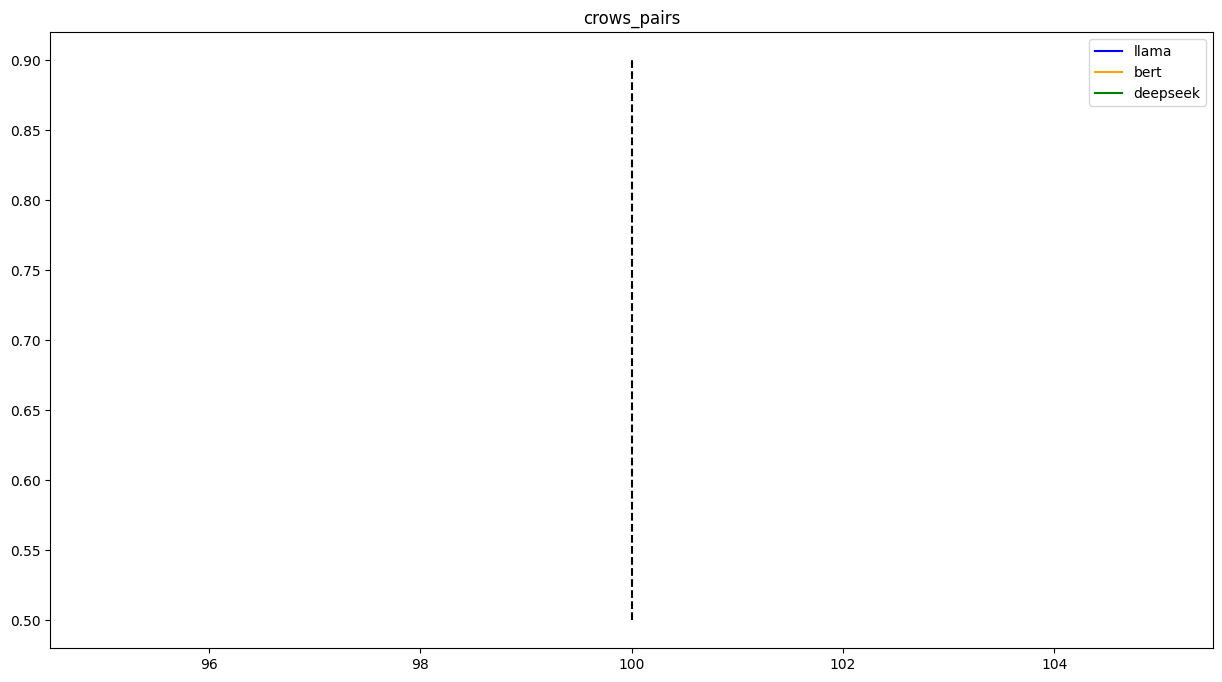

In [13]:
for dataset in ['bios-supervised', 'sbic', 'jigsaw', 'stereoset', 'crows_pairs']:
    fig, ax = plt.subplots(figsize=(15,8))
    res_base_ = res_base[res_base['dataset'] == dataset]
    res_base_ = aggregate_results(res_base_, sel_cols=['model type'], target_col='F1')
    ax.vlines(100, 0.5, 0.9, linestyle='--', colors='black')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
    for i, model_type in enumerate(['llama', 'bert', 'deepseek']): #, 'opt', 'pythia']):#, 'text-embedding-3']):
        res_ = res_pie[res_pie['model type'] == model_type]
        res_ = res_[res_['dataset'] == dataset]
        res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')
        
        emb_sizes = list(set(res_['emb size']))
        ax.vlines(emb_sizes, 0.5, 0.9, linestyle='--', colors=colors[i])
    
        #max_y = np.max(res_agg['F1'])
        max_y = np.max(res_base[res_base['model type'] == model_type]['F1'])
        ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
        
        y1 = res_agg['F1']-res_agg['F1 var']
        y2 = res_agg['F1']+res_agg['F1 var']
        ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
        ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
    ax.legend()
    ax.set_title(dataset)

In [ ]:
for dataset in ['bios-supervised', 'sbic', 'jigsaw', 'stereoset', 'crows_pairs']:
    fig, ax = plt.subplots(figsize=(15,8))
    res_base_ = res_base[res_base['dataset'] == dataset]
    res_base_ = aggregate_results(res_base_, sel_cols=['model type'], target_col='F1')
    ax.vlines(100, 0.5, 0.9, linestyle='--', colors='black')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
    for i, model_type in enumerate(['llama', 'bert', 'deepseek', 'text-embedding-3']):#, 'text-embedding-3']):
        res_ = res_pie[res_pie['model type'] == model_type]
        res_ = res_[res_['dataset'] == dataset]
        res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

        emb_sizes = list(set(res_['emb size']))
        ax.vlines(emb_sizes, 0.5, 0.9, linestyle='--', colors=colors[i])
    
        max_y = np.max(res_base_[res_base_['model type'] == model_type]['F1'])
        ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
        
        y1 = res_agg['F1']-res_agg['F1 var']
        y2 = res_agg['F1']+res_agg['F1 var']
        ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
        ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
    ax.legend()
    ax.set_title(dataset)

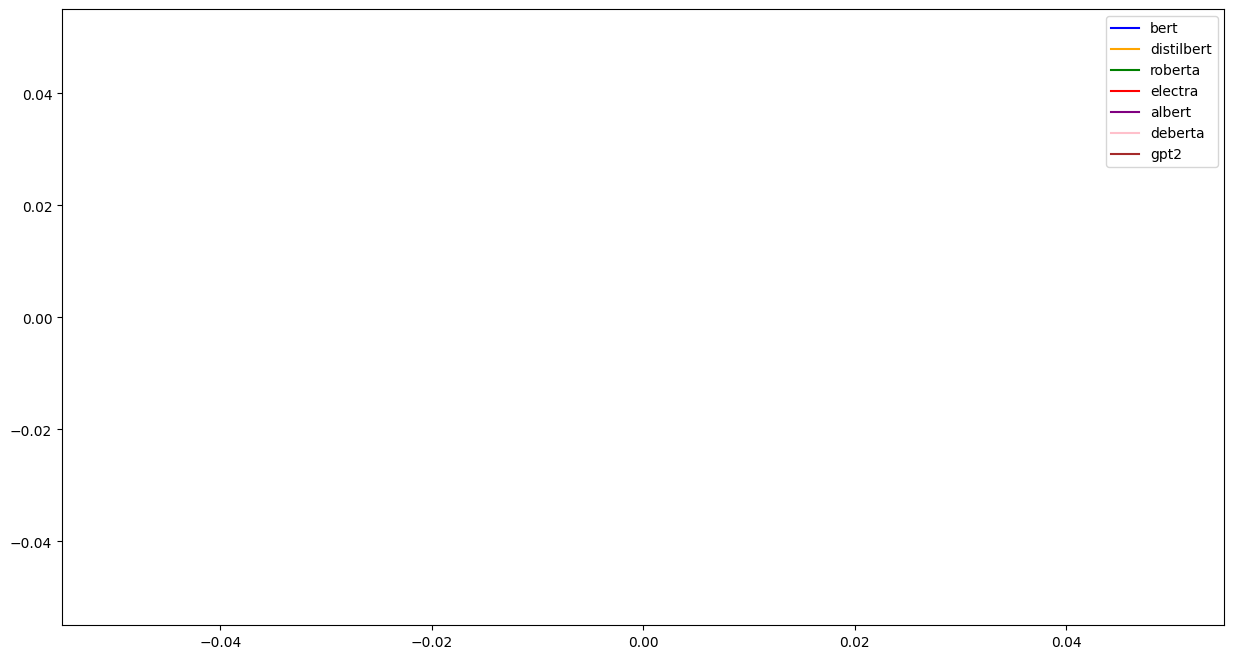

In [332]:
fig, ax = plt.subplots(figsize=(15,8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
for i, model_type in enumerate(['bert', 'distilbert', 'roberta', 'electra', 'albert', 'deberta', 'gpt2']):
    res_ = res_pie[res_pie['model type'] == model_type]
    res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

    max_y = np.max(res_agg['F1'])
    ax.hlines([max_y], xmin=0, xmax=1500, colors=colors[i])
    
    y1 = res_agg['F1']-res_agg['F1 var']
    y2 = res_agg['F1']+res_agg['F1 var']
    ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
    ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
ax.legend()

In [114]:
def group2attr(group):
    if group in ['white', 'black', 'asian', 'latin-american', 'hispanic', 'middle eastern', 'african', 'hispanic/latino', 'middle east', 'south east asian', 'latino', 'european']:
        return 'ethnicity'
    if group in ['male', 'female', 'trans', 'lgbtq+', 'transgender']:
        return 'gender'
    if group in ['homosexual', 'bisexual', 'heterosexual', 'homosexual_gay_or_lesbian']:
        return 'sex_or'
    if group in ['christian', 'muslim/islam', 'muslim', 'jewish']:
        return 'religion'
    if group in ['disability', 'intellectual_or_learning_disability', 'mental disability', 'mental illness', 'mental illness/ disorder', 'physical disability', 'physical_disability', 'psychiatric_or_mental_illness']:
        return 'disability'
    return 'n/a'

res_concept['attribute'] = ''
for idx in res_concept.index:
    res_concept.loc[idx, 'attribute'] = group2attr(res_concept.loc[idx,'group (test)'])

In [115]:
res_agg = aggregate_results(res_, sel_cols=['dataset,'], target_col='F1')

KeyError: 'dataset,'

## Concept plots

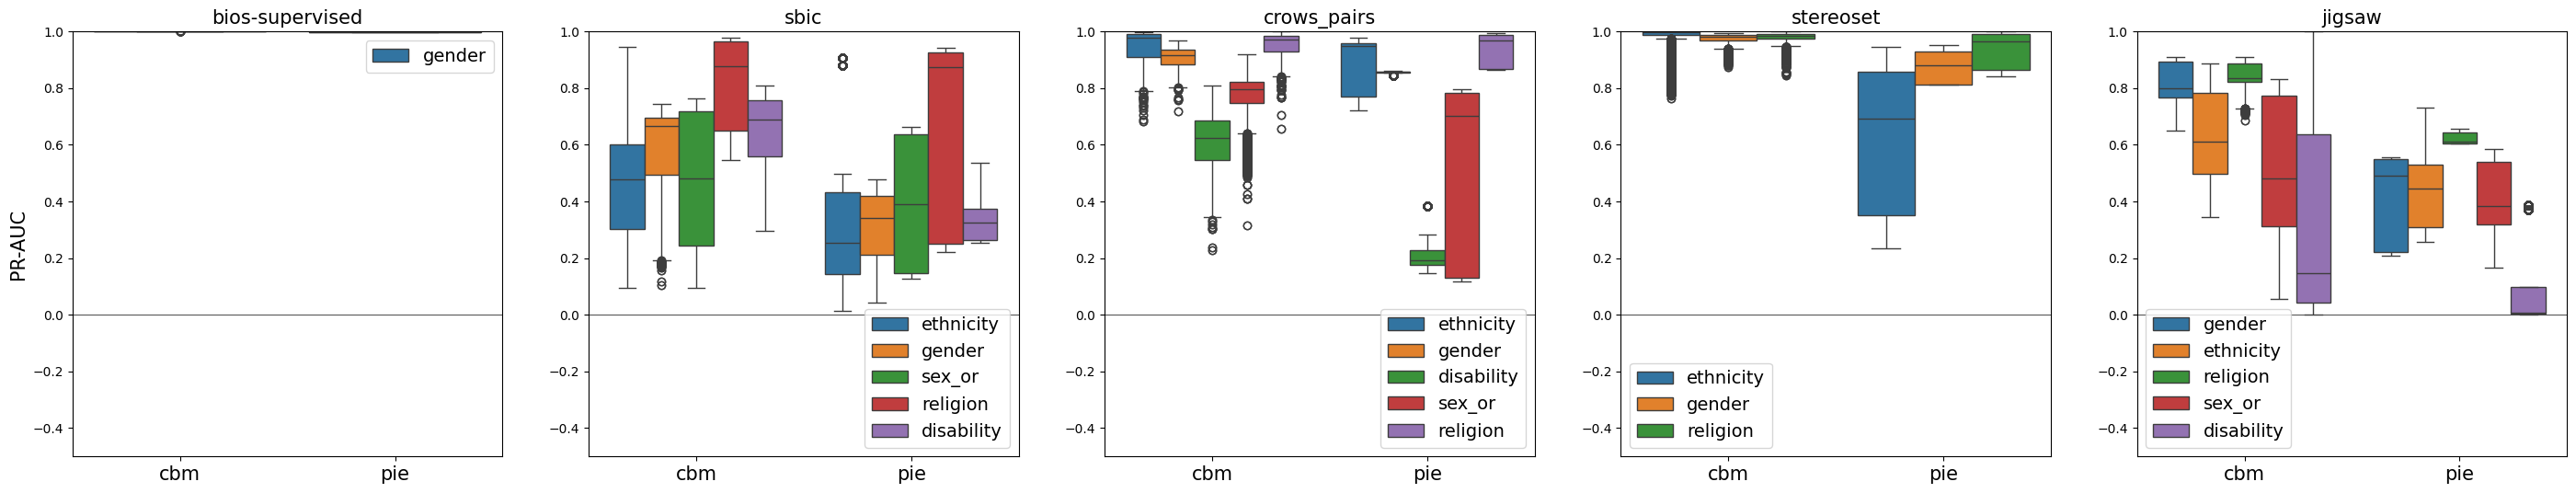

In [116]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='attribute', remove_legend=False)

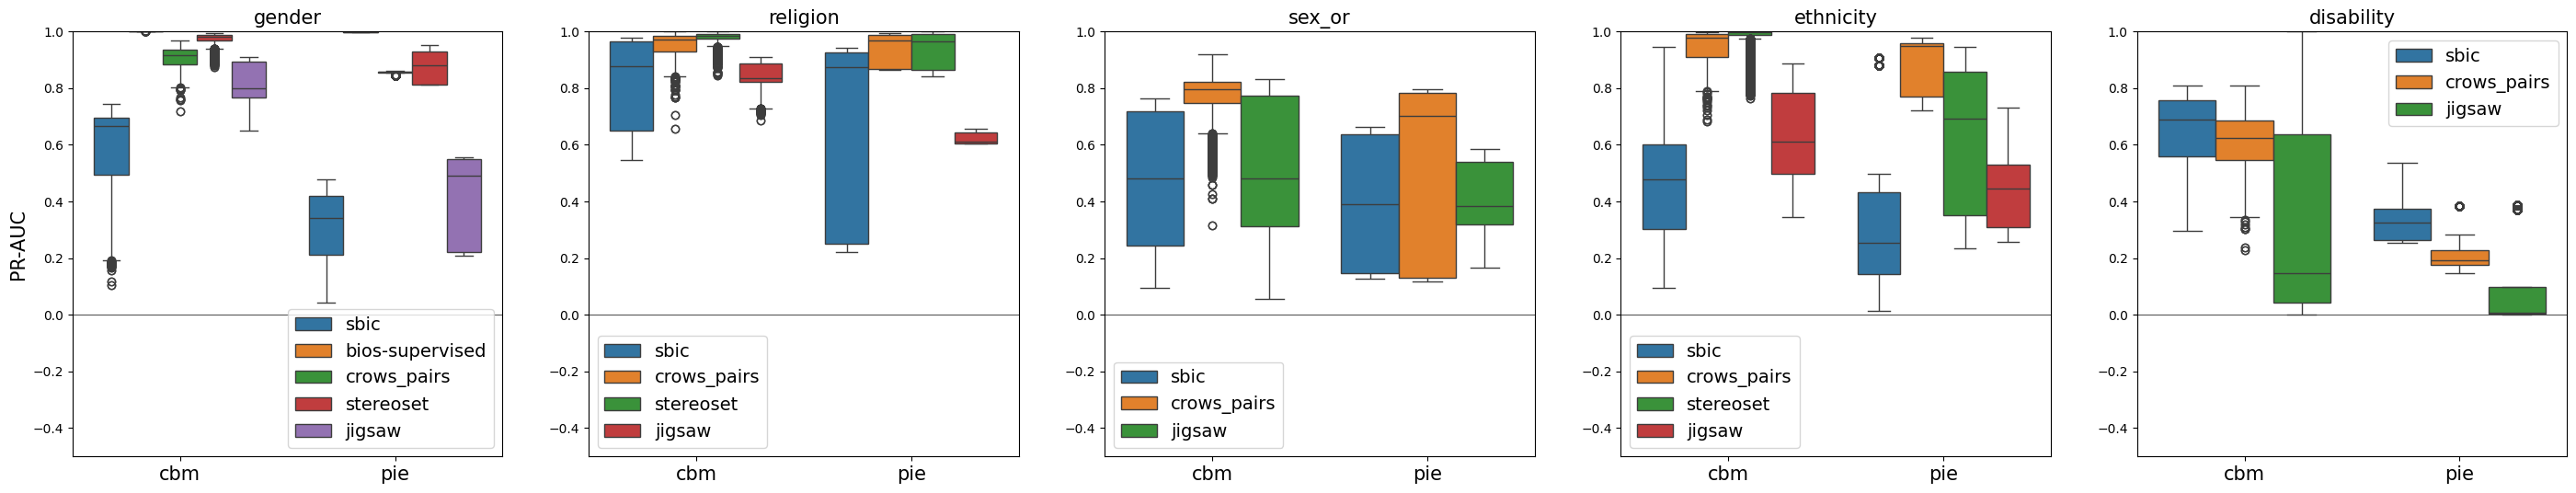

In [117]:
multipot(res_concept, subplot_col='attribute', xcol='method', ycol='PR-AUC', huecol='dataset', remove_legend=False)

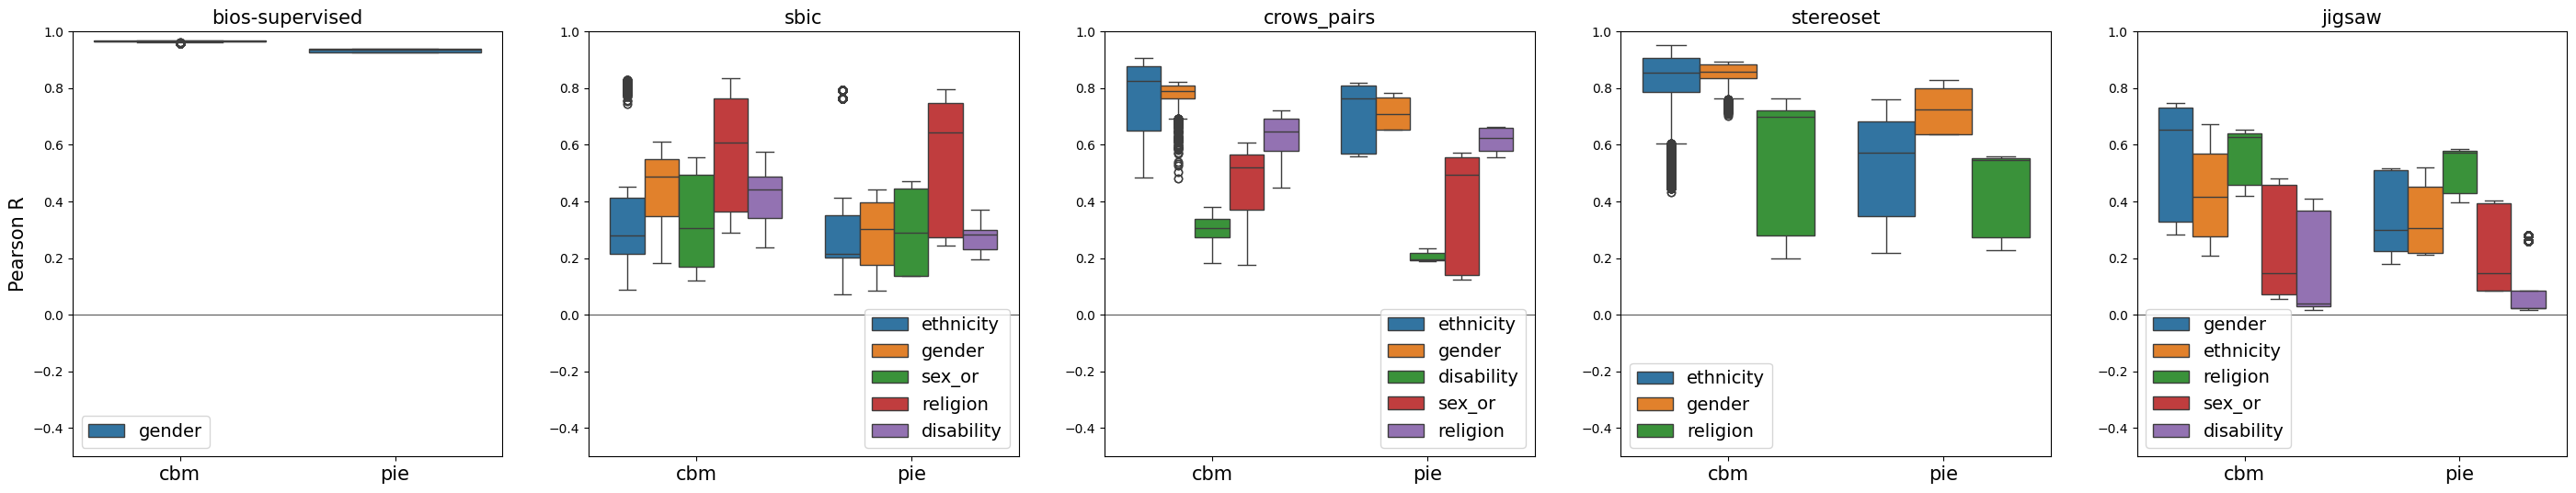

In [118]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='Pearson R', huecol='attribute', remove_legend=False)

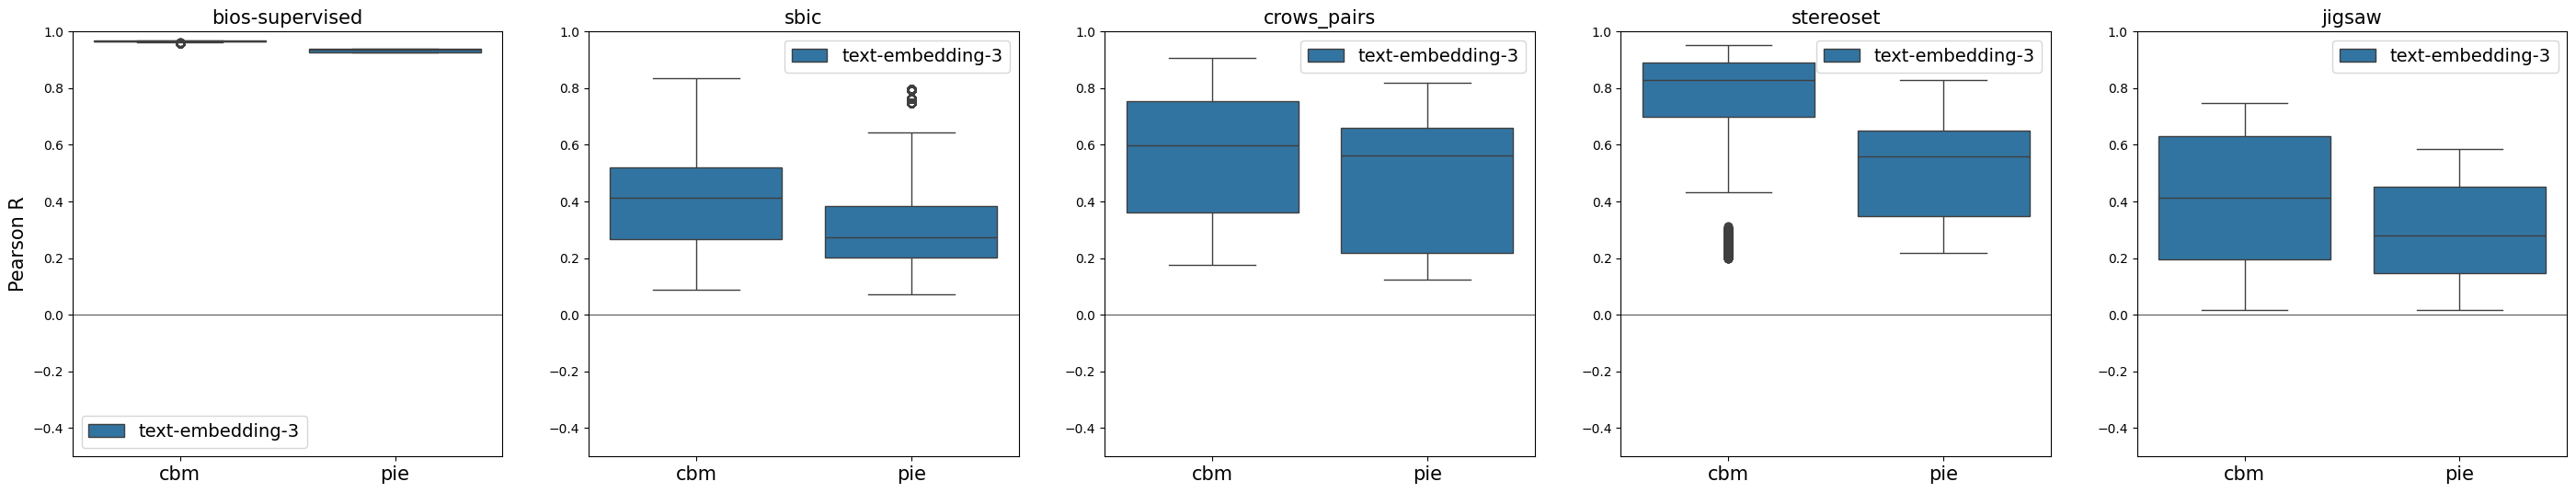

In [119]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='Pearson R', huecol='model type', remove_legend=False)

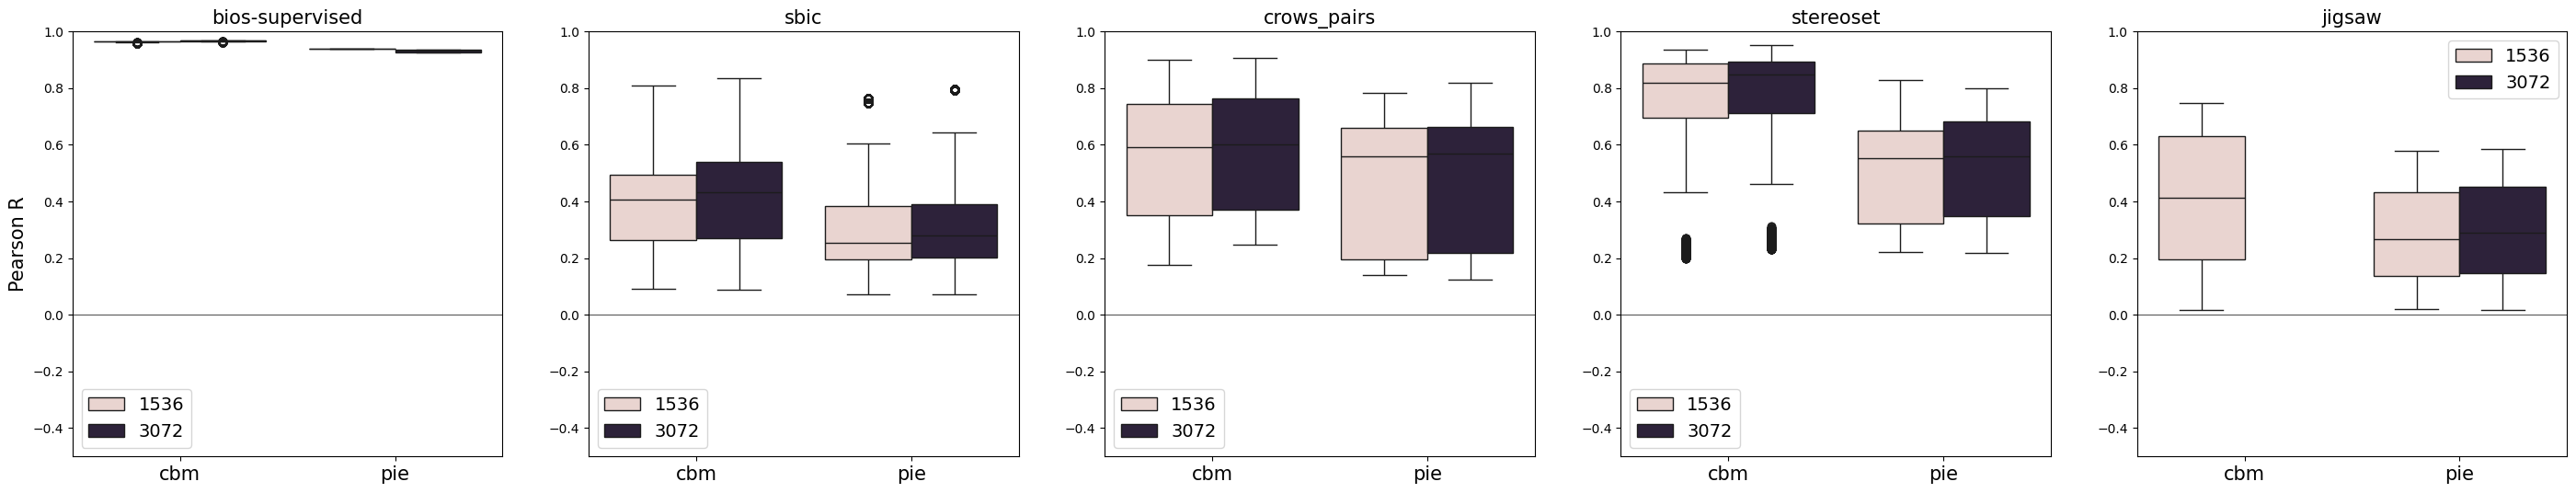

In [32]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='Pearson R', huecol='emb size', remove_legend=False)

In [33]:
results_pie_concept[results_pie_concept['dataset'] == 'twitterAAE']

,index,dataset,model,model type,architecture,method,pooling,classifier,clf hidden size factor,emb size,...,optimizer,lr,loss,group (pie),group (test),Pearson R,pvalue,PR-AUC,Epochs,concepts


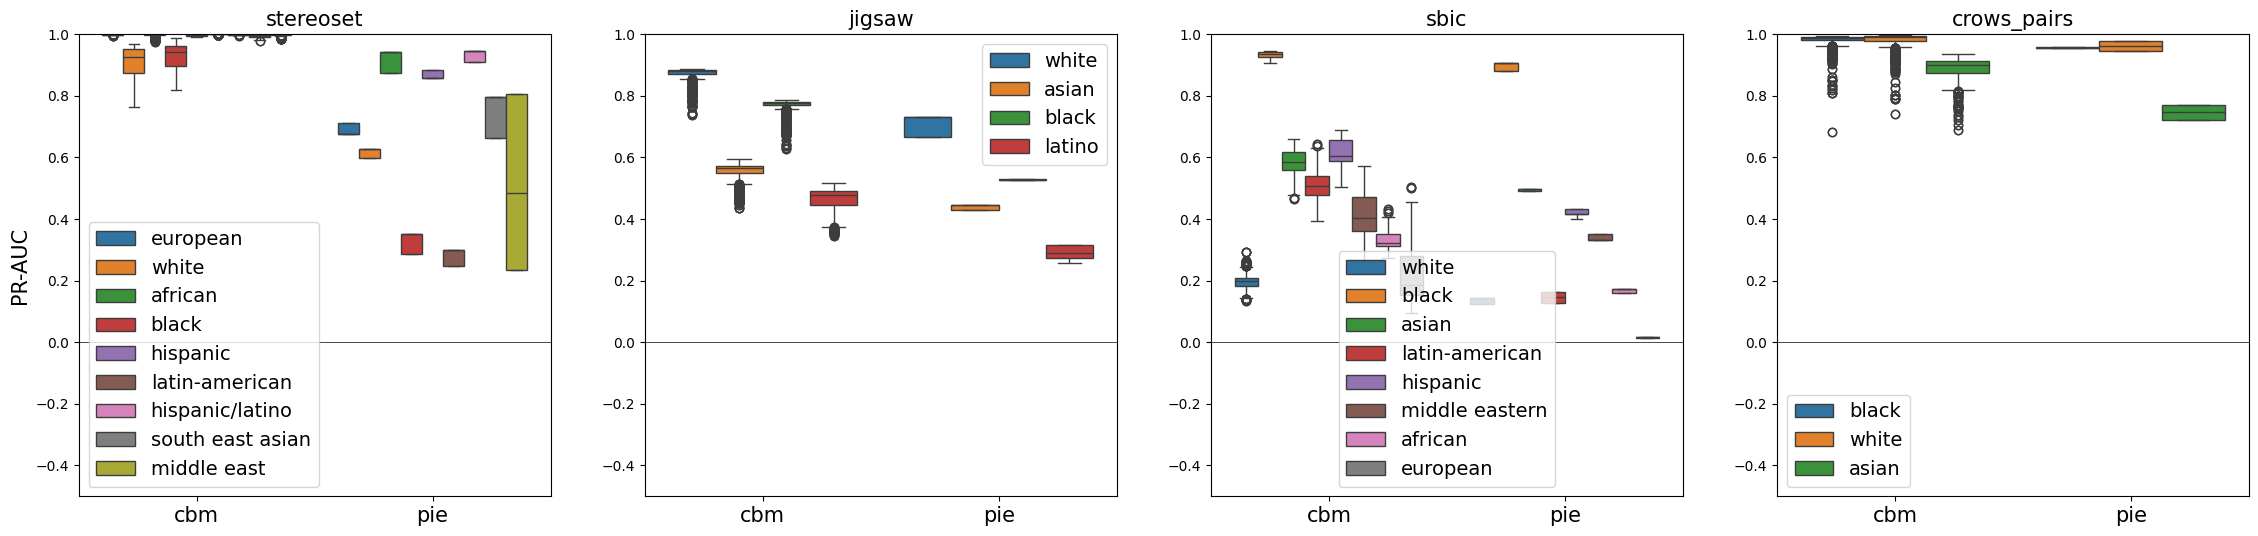

In [34]:
res = res_concept[res_concept['attribute'] == 'ethnicity']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

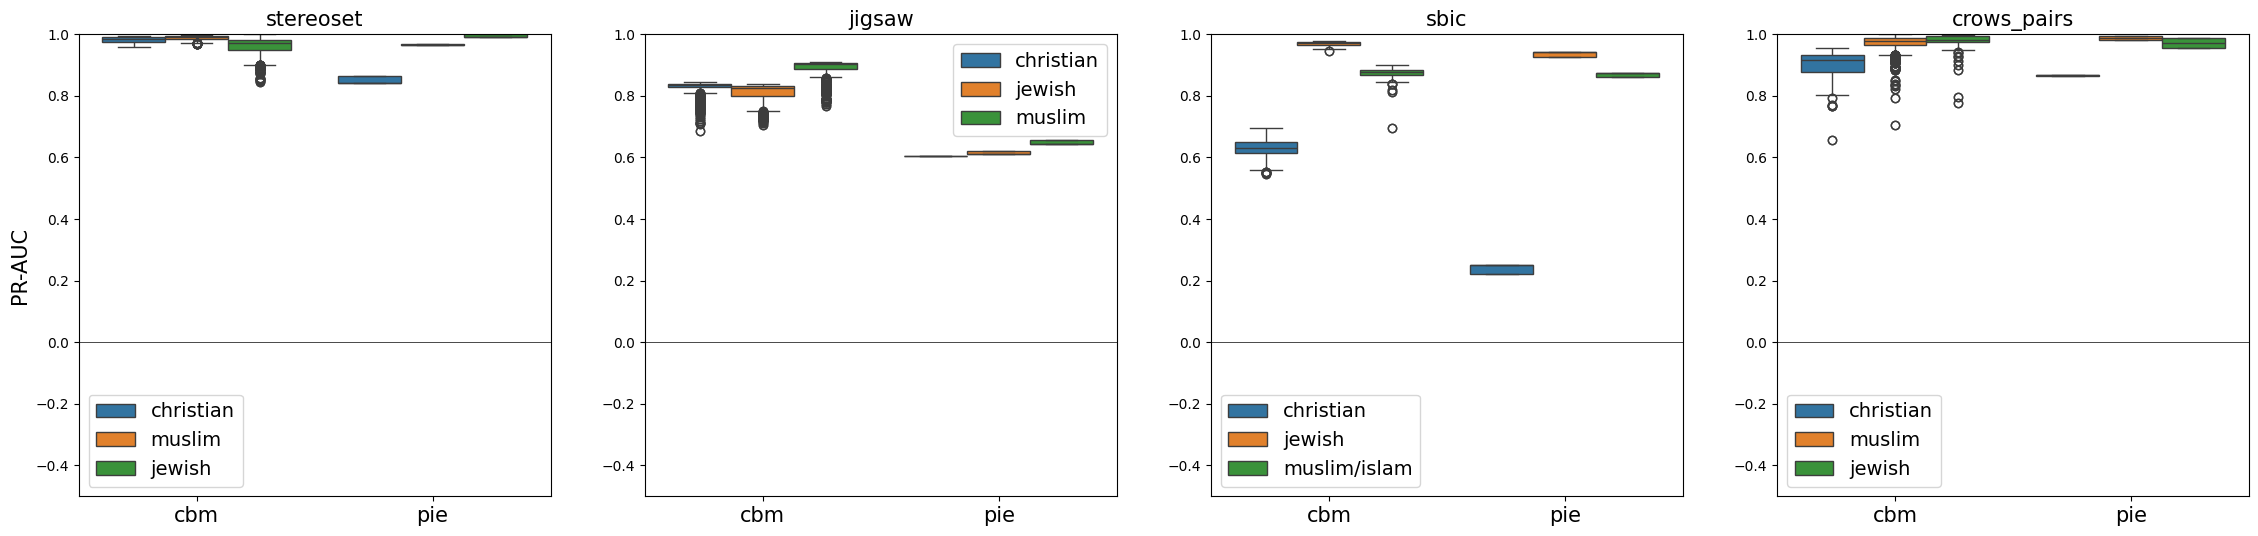

In [35]:
res = res_concept[res_concept['attribute'] == 'religion']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

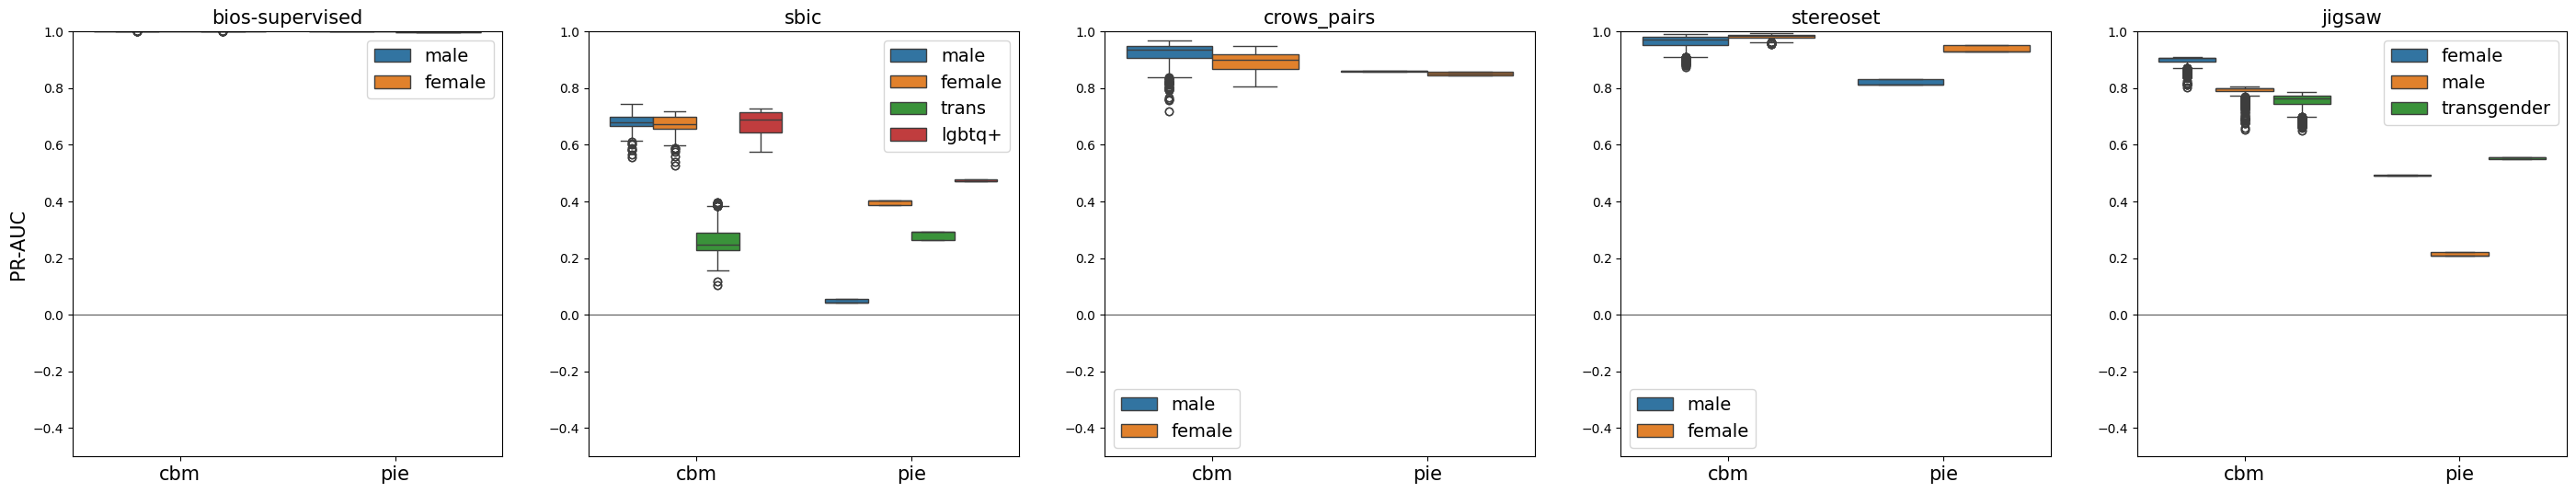

In [36]:
res = res_concept[res_concept['attribute'] == 'gender']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

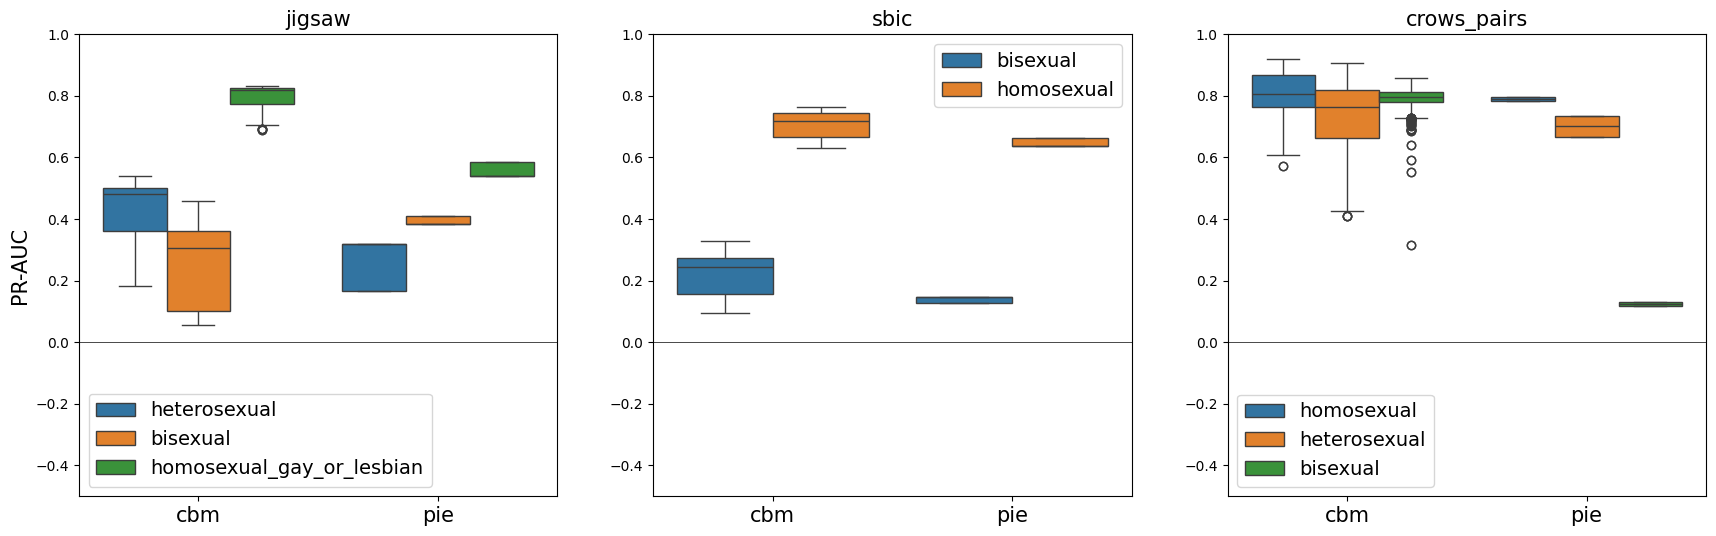

In [37]:
res = res_concept[res_concept['attribute'] == 'sex_or']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

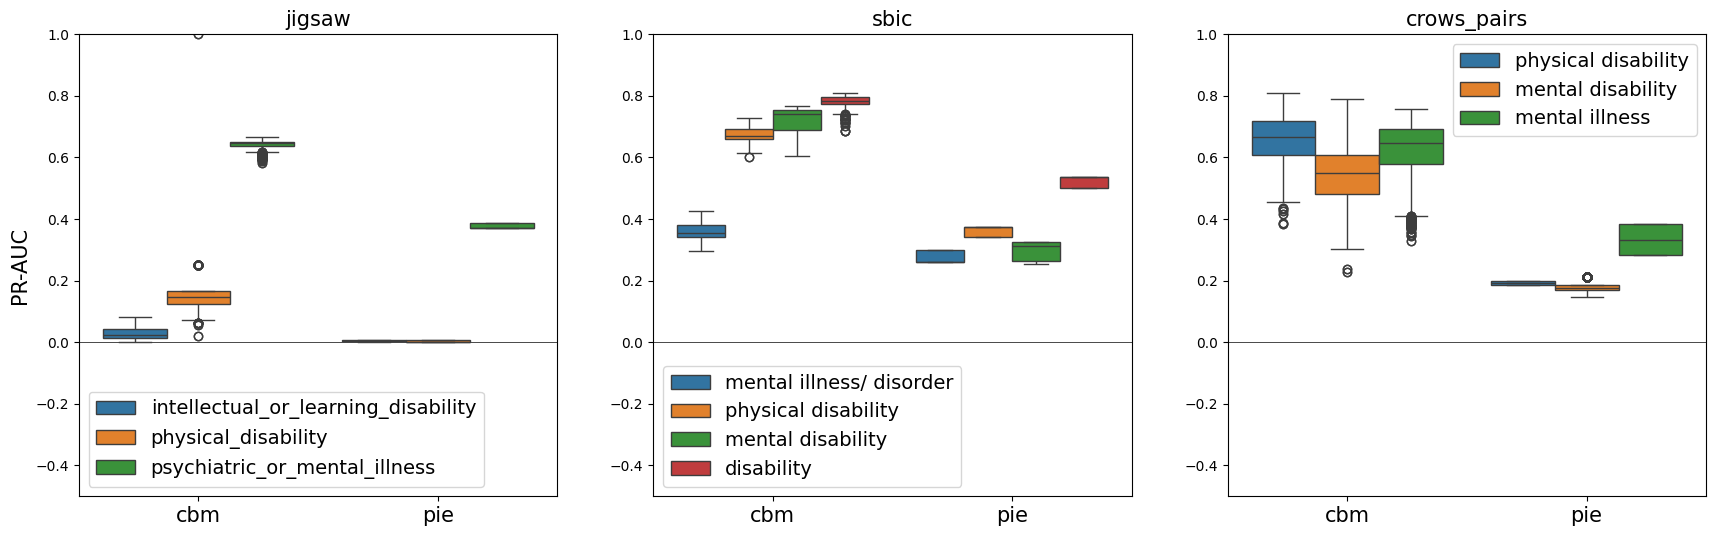

In [38]:
res = res_concept[res_concept['attribute'] == 'disability']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

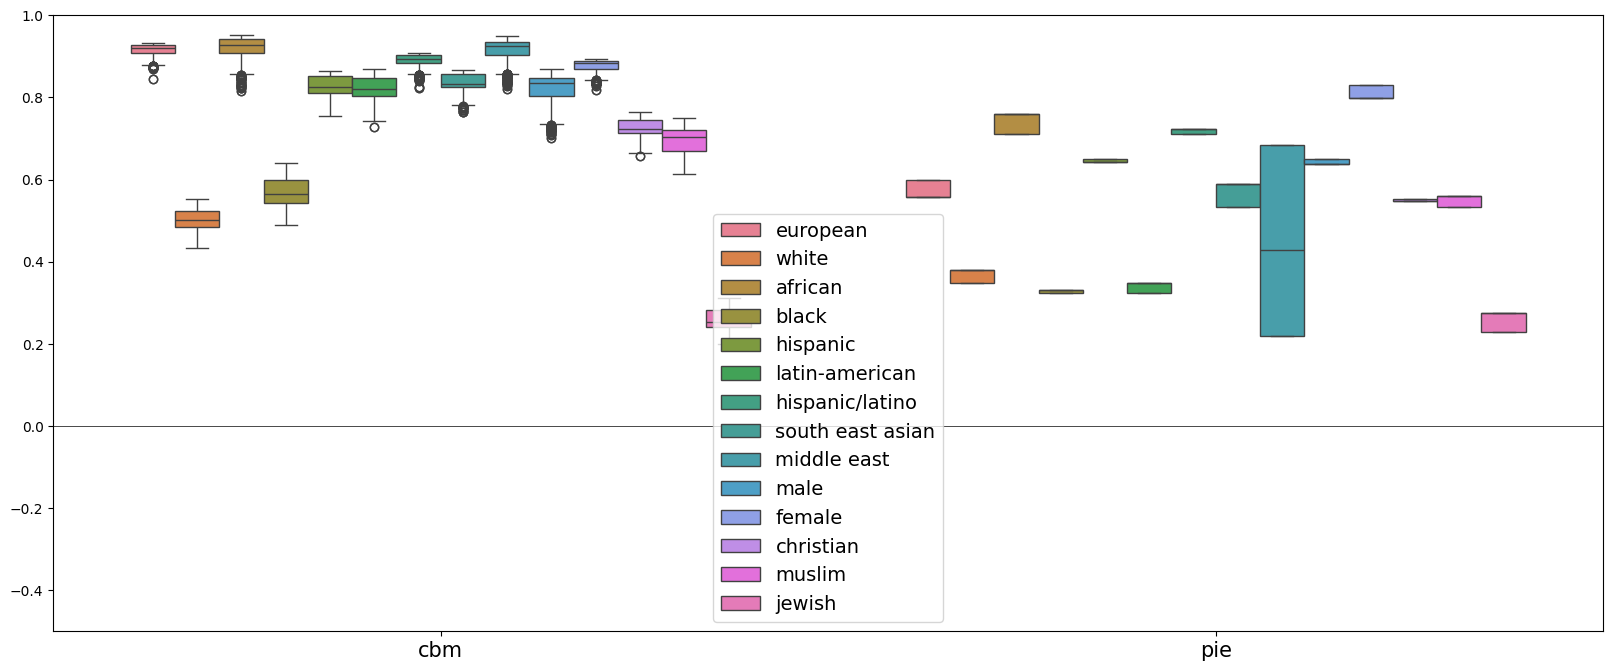

In [39]:
res = res_concept[res_concept['dataset'] == 'stereoset']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

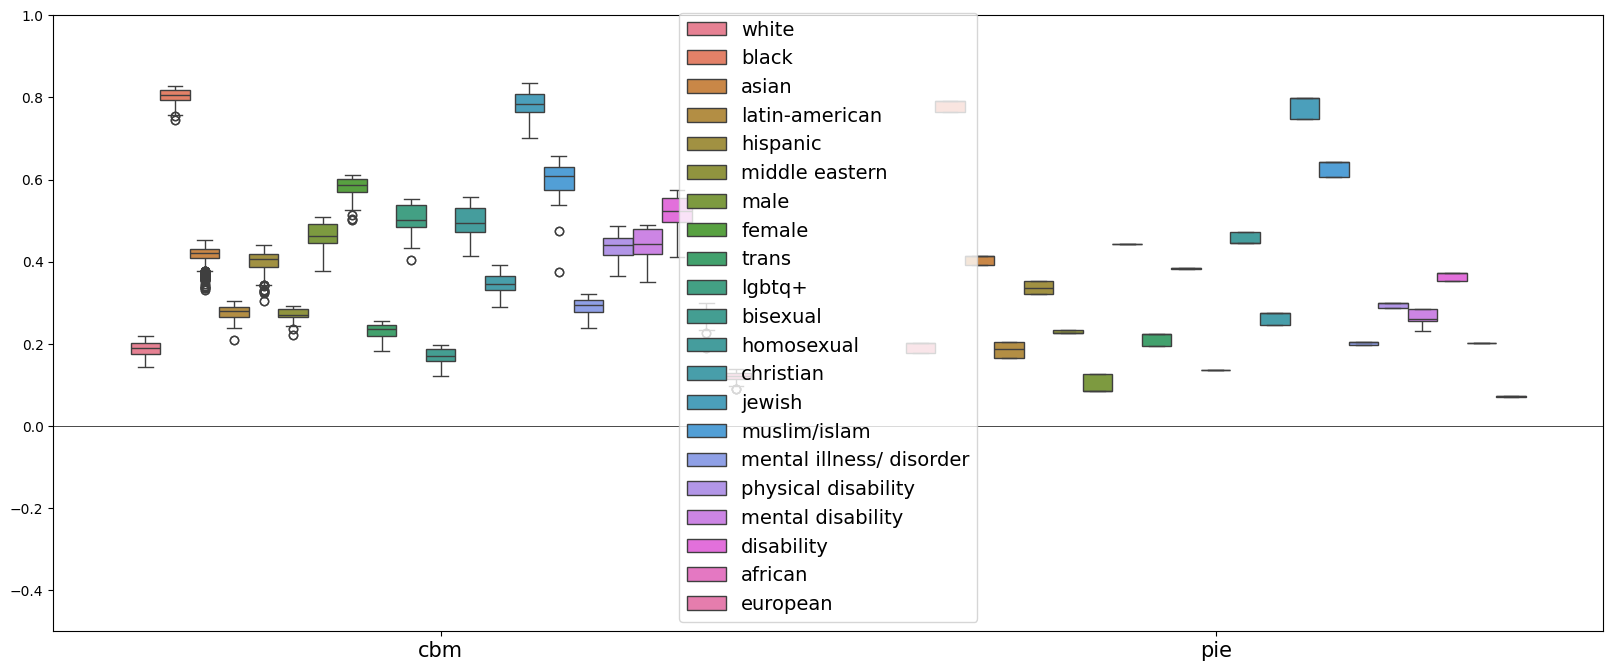

In [40]:
res = res_concept[res_concept['dataset'] == 'sbic']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

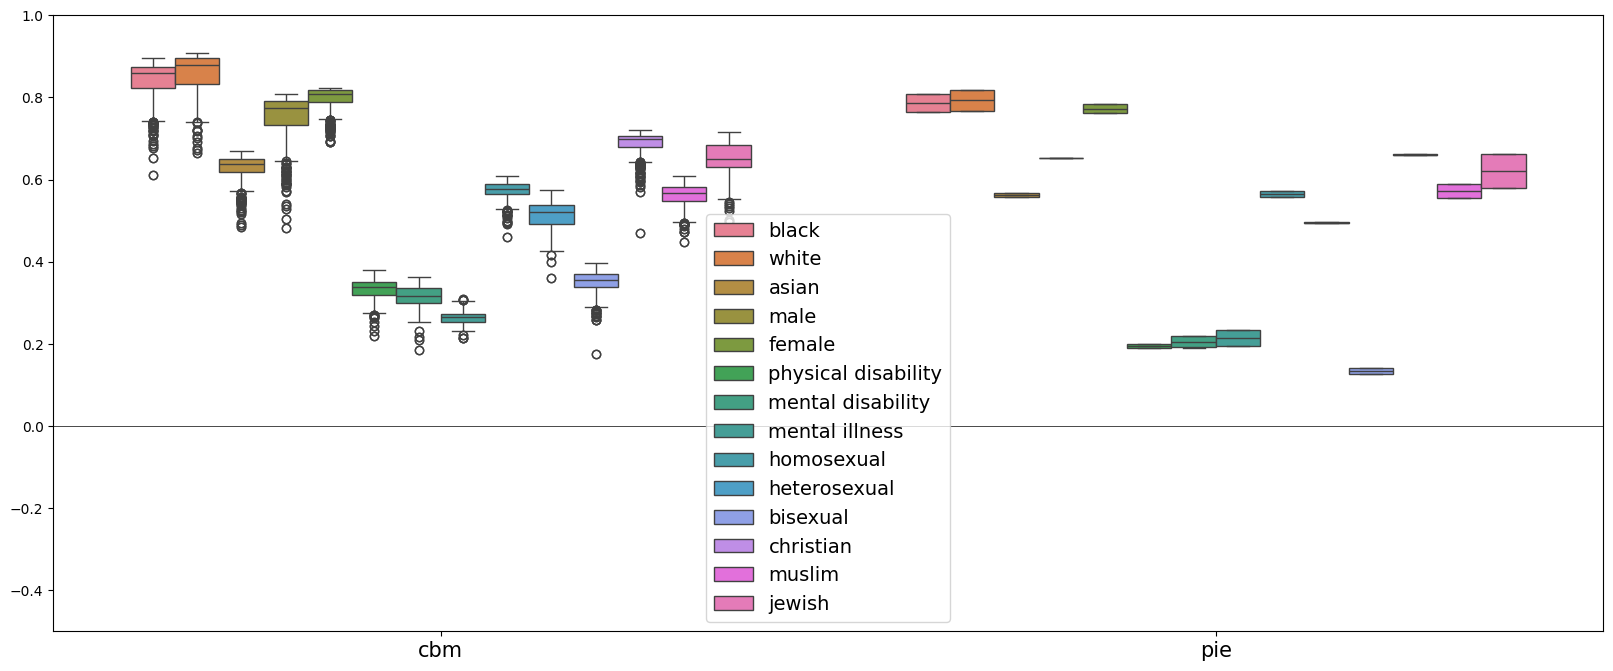

In [41]:
res = res_concept[res_concept['dataset'] == 'crows_pairs']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

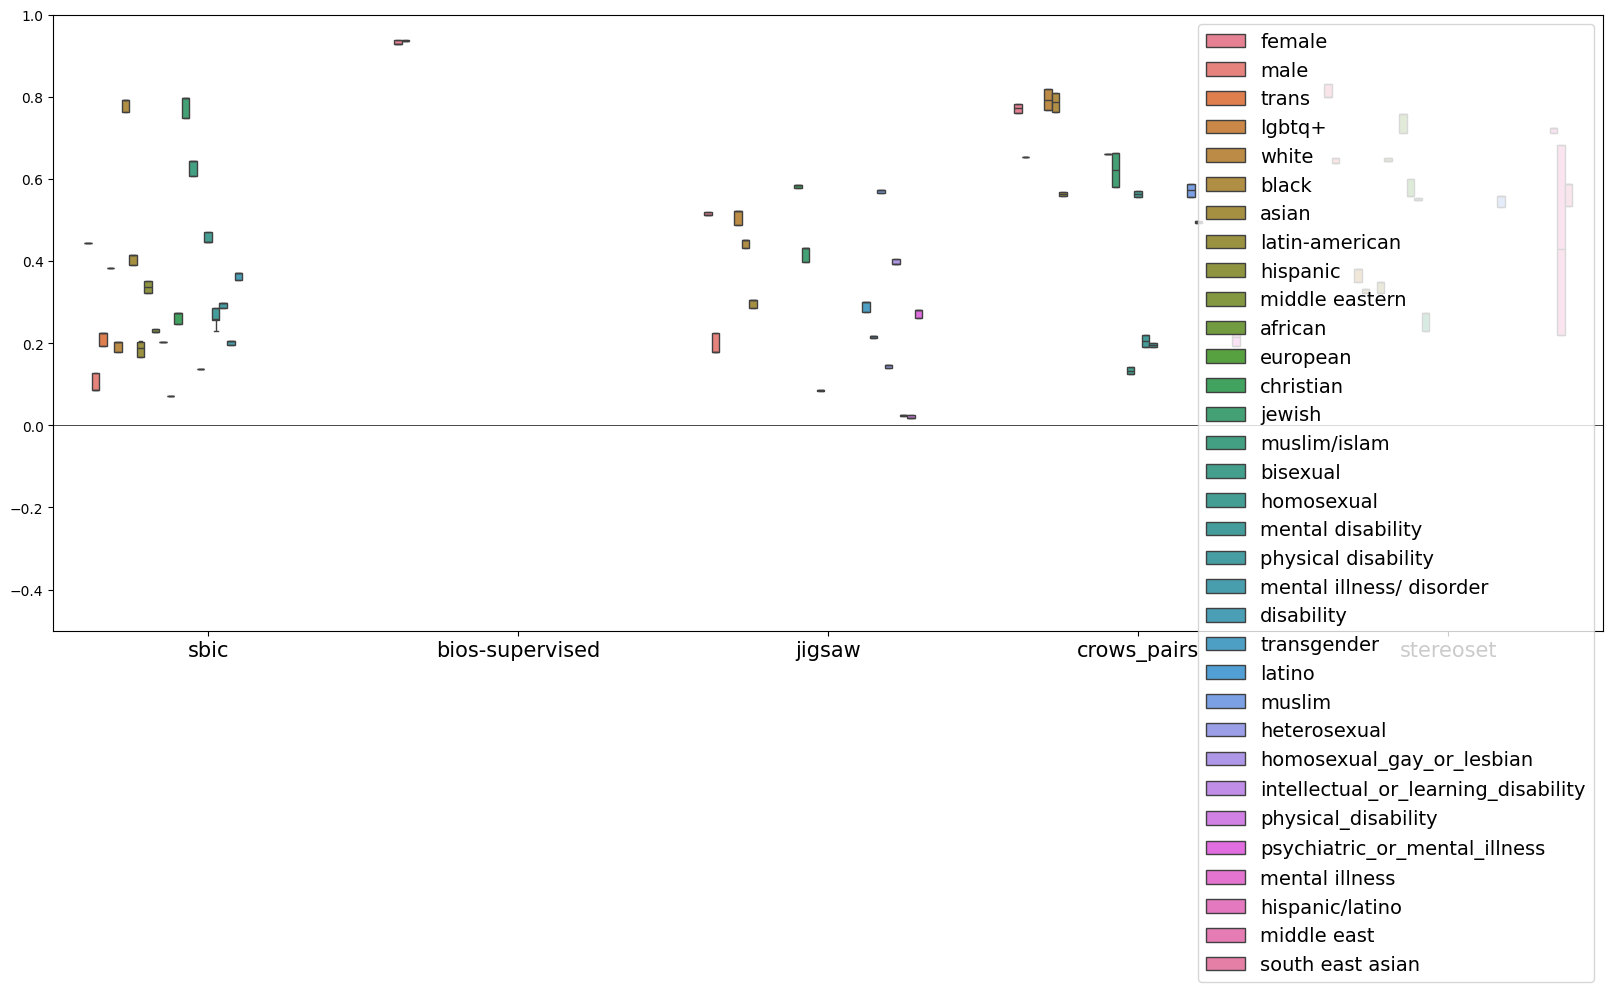

In [42]:
#res = res_concept[res_concept['dataset'] == 'crows_pairs']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='dataset', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

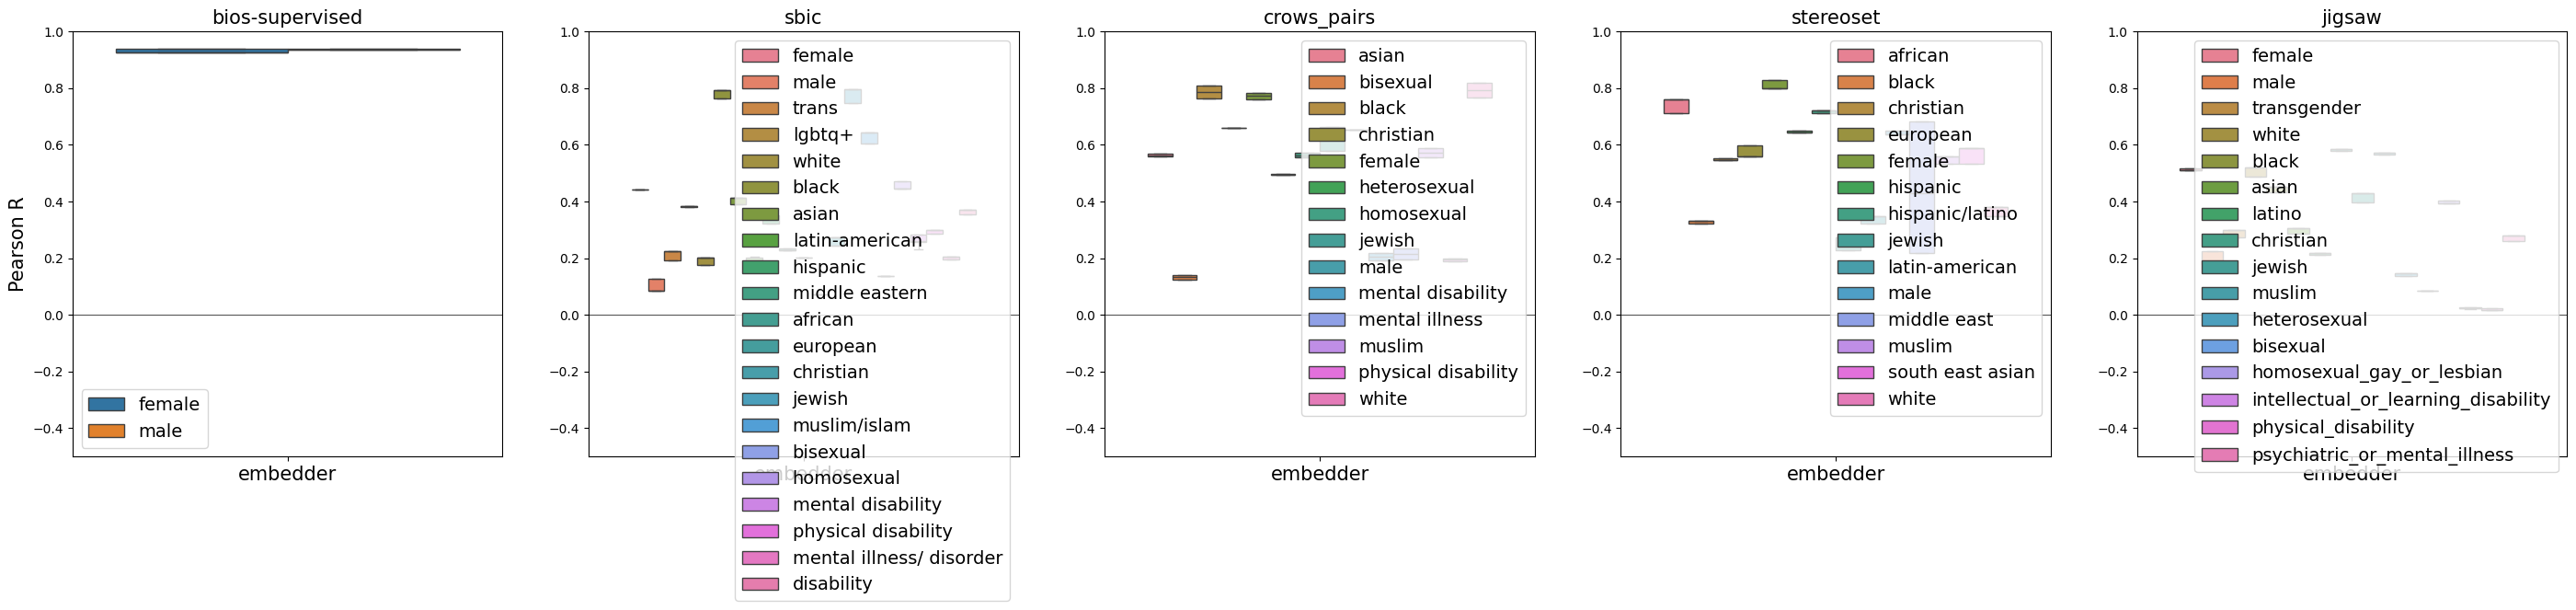

In [43]:
multipot(results_pie_concept, subplot_col='dataset', xcol='architecture', ycol='Pearson R', huecol='group (test)', remove_legend=False)

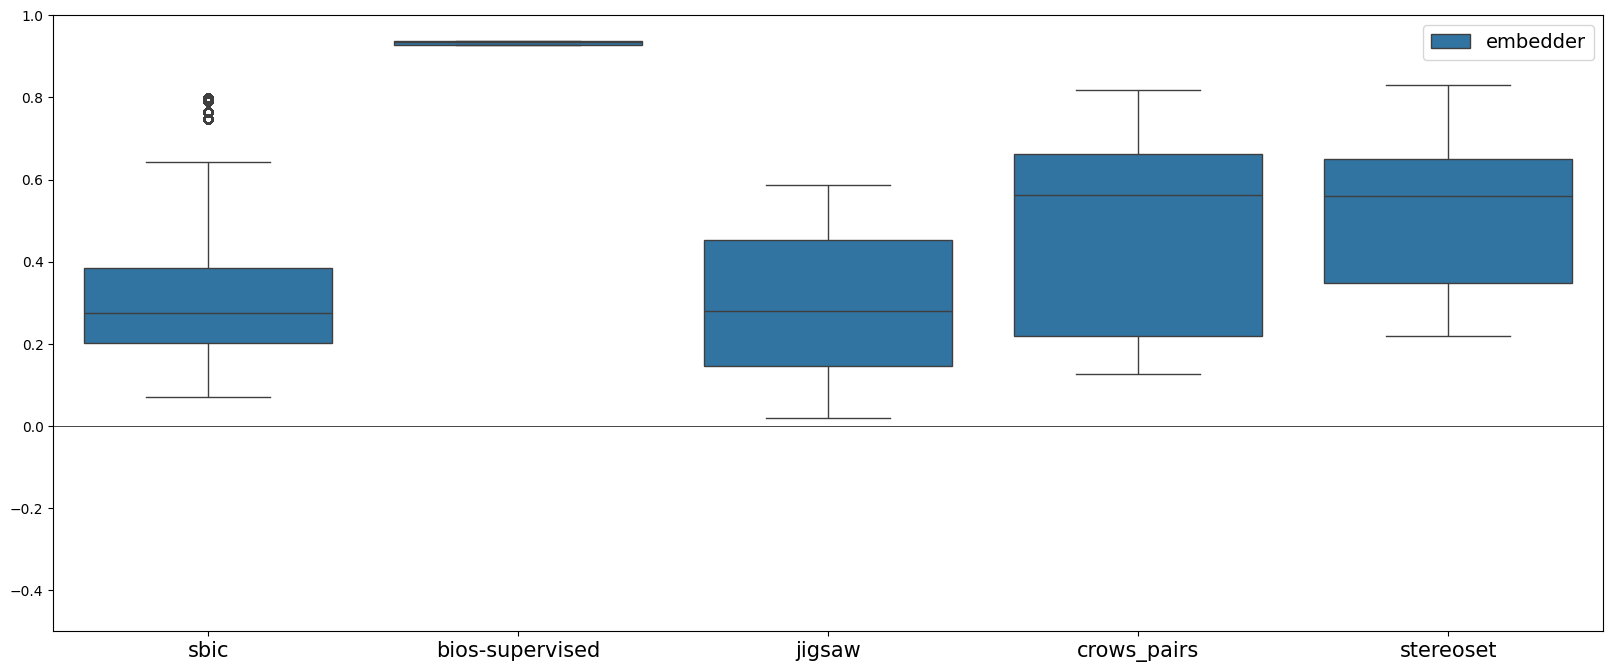

In [44]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='dataset', ycol='Pearson R', huecol='architecture', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

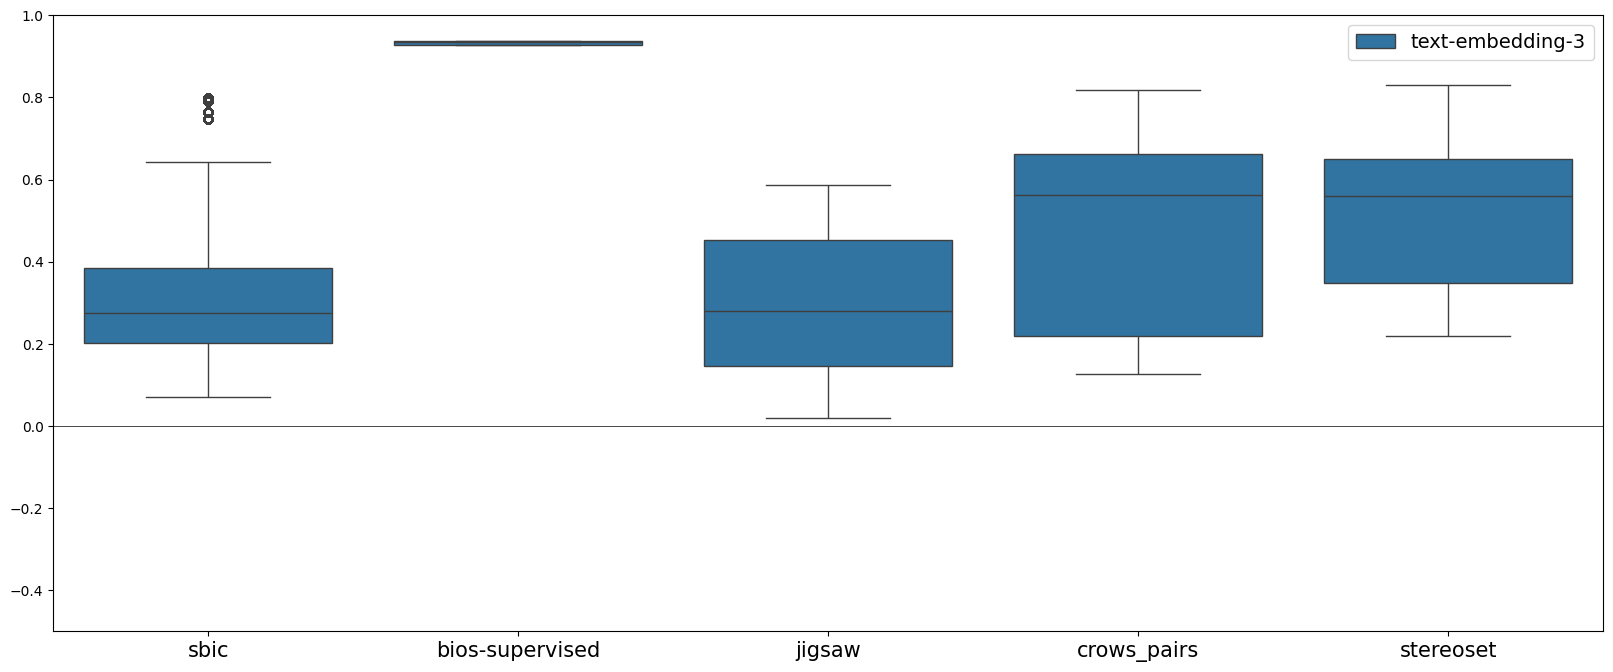

In [45]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='dataset', ycol='Pearson R', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

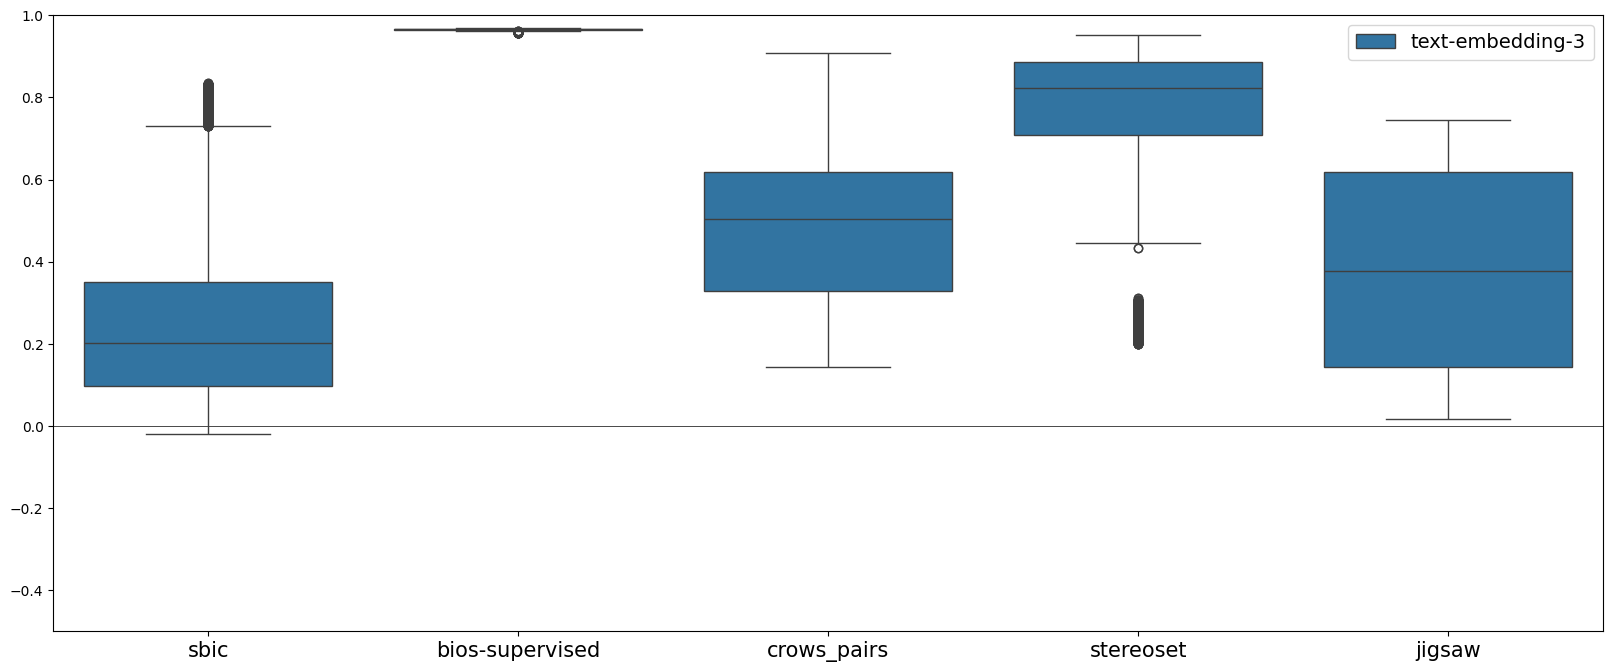

In [46]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_cbm_concept, ax, xcol='dataset', ycol='Pearson R', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

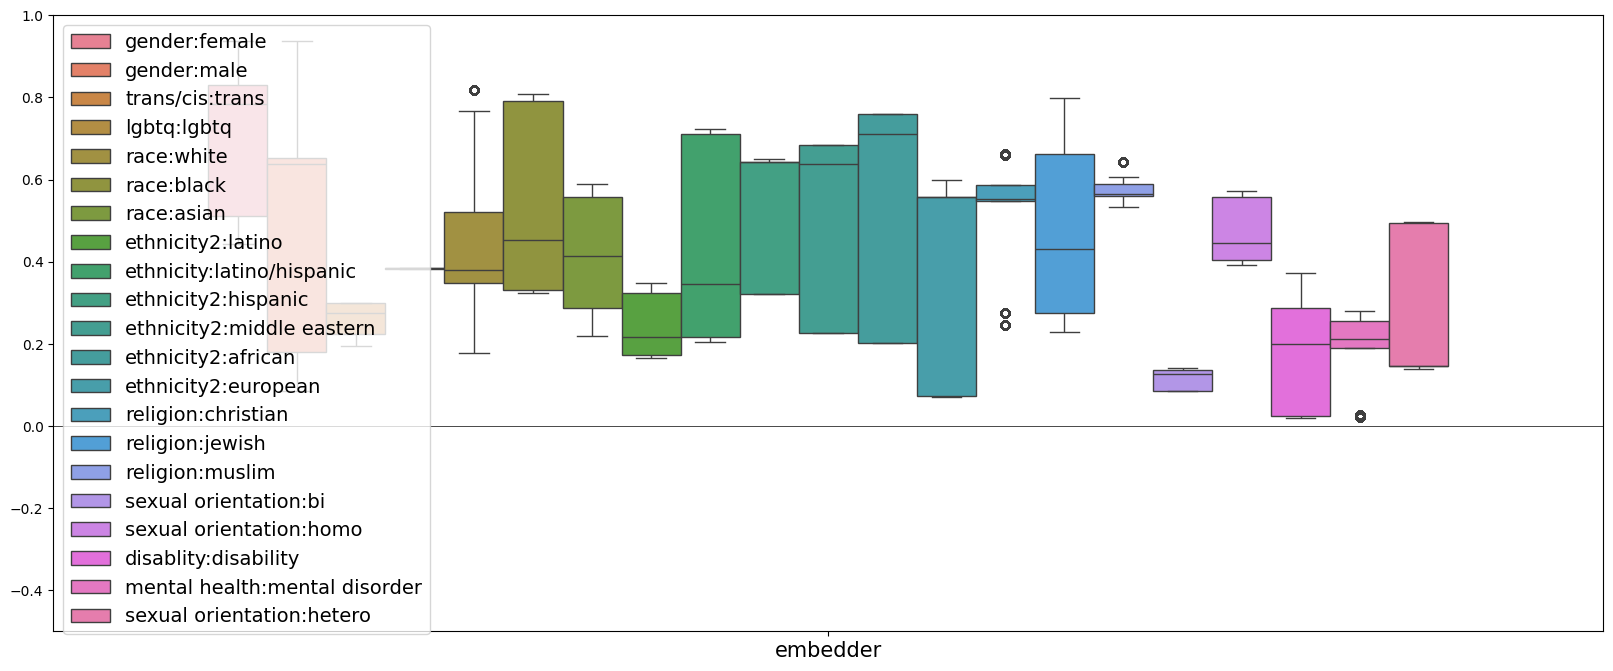

In [47]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='architecture', ycol='Pearson R', huecol='group (pie)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

In [125]:
set(results_pie_concept['model'])

{'EleutherAI/pythia-1.4b',
 'EleutherAI/pythia-160m',
 'EleutherAI/pythia-1b',
 'EleutherAI/pythia-410m',
 'albert-base-v2',
 'albert-large-v2',
 'bert-base-uncased',
 'bert-large-uncased',
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B',
 'deepseek-ai/deepseek-llm-7b-base',
 'deepseek-ai/deepseek-llm-7b-chat',
 'distilbert-base-uncased',
 'distilgpt2',
 'distilroberta-base',
 'facebook/opt-1.3b',
 'facebook/opt-125m',
 'facebook/opt-350m',
 'google/electra-base-discriminator',
 'google/electra-base-generator',
 'google/electra-large-discriminator',
 'google/electra-large-generator',
 'gpt2',
 'gpt2-large',
 'gpt2-medium',
 'meta-llama/Llama-3.2-1B',
 'meta-llama/Llama-3.2-1B-Instruct',
 'meta-llama/Llama-3.2-3B',
 'meta-llama/Llama-3.2-3B-Instruct',
 'microsoft/deberta-v3-base',
 'microsoft/deberta-v3-large',
 'microsoft/deberta-v3-small',
 'roberta-base',
 'roberta-large',
 'xlnet/xlnet-base-cased',
 'xlnet/xlnet-large-cased'}